# Cache Performance Analysis (EDA)

This notebook is for Exploratory Data Analysis of the cache performance test results. We will load the detailed CSV file generated by the `combine_detailed_results.ps1` script and perform analysis to compare the performance of different caching strategies.

In [ ]:
import pandas as pd
import glob
import os

# Cache Performance Analysis - Exploratory Data Analysis

**Objective**: Analyze the performance impact of caching strategies across different payload sizes and endpoints.

**Experiment Setup**:
- **3 Scenarios**: No Cache, Cache HIT, Cache MISS
- **2 Endpoints**: Automatic (aggregate operations) and Income (high payload)
- **7 Payload Sizes**: 10, 100, 250, 500, 1000, 2000, 4000 records
- **Multiple Runs**: 5-10 runs per configuration for statistical reliability
- **Metrics**: APDEX scores, response times, resource usage (RAM, CPU)

---

## 1. Setup and Data Loading

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [ ]:
# Load the dataset
df = pd.read_csv('./results_stable/detailed_all_tests_20251105_083402.csv') # avg

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.shape[1]} metrics")
print(f"Rows: {df.shape[0]} test runs\n")

# Show first few rows
df.head()

Dataset Shape: (180, 116)

Columns: 116 metrics
Rows: 180 test runs



,TestRunID,Endpoint,PayloadSize,RunNumber,Timestamp,FileName,APDEX_T_Threshold,APDEX_F_Threshold,API_NoCache_URL,API_WithCache_URL,...,APDEX_Improvement_HitVsMiss,NoCache_Range_ms,CacheHit_Range_ms,CacheMiss_Range_ms,NoCache_Variability_ms,CacheHit_Variability_ms,CacheMiss_Variability_ms,NoCache_TailLatencyRatio,CacheHit_TailLatencyRatio,CacheMiss_TailLatencyRatio
0,10_automatic_run1_20251104_220254,automatic,10,1,11/4/2025 10:04:25 PM,test_10_records_10_automatic_run1_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,0.0,85.15,3.02,87.24,3.20,0.20,1.83,1.04,1.18,1.01
1,10_automatic_run10_20251104_221856,automatic,10,10,11/4/2025 10:20:27 PM,test_10_records_10_automatic_run10_20251104_22...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,0.0,52.55,4.55,34.44,3.30,0.34,2.27,1.03,1.29,1.03
2,10_automatic_run2_20251104_220441,automatic,10,2,11/4/2025 10:06:12 PM,test_10_records_10_automatic_run2_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,0.0,16.25,1.31,35.83,2.66,0.31,4.54,1.04,1.22,1.02
3,10_automatic_run3_20251104_220628,automatic,10,3,11/4/2025 10:07:58 PM,test_10_records_10_automatic_run3_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,0.0,31.49,1.65,56.25,4.41,0.35,2.04,1.05,1.26,1.02
4,10_automatic_run4_20251104_220815,automatic,10,4,11/4/2025 10:09:46 PM,test_10_records_10_automatic_run4_20251104_220...,500,1500,https://hightide-no-cache.sple.my.id/call/auto...,https://hightide-cache.sple.my.id/call/automat...,...,0.0,24.72,7.17,55.13,3.06,0.28,1.53,1.03,1.16,1.02


## 2. Data Overview and Quality Check

In [ ]:
# Dataset summary
print("="*70)
print("DATASET SUMMARY")
print("="*70)

print(f"\n📊 Test Coverage:")
print(f"  • Endpoints: {df['Endpoint'].nunique()} ({', '.join(df['Endpoint'].unique())})")
print(f"  • Payload Sizes: {df['PayloadSize'].nunique()} ({sorted(df['PayloadSize'].unique())})")
print(f"  • Total Test Runs: {len(df)}")

print(f"\n🔢 Tests per Endpoint:")
print(df['Endpoint'].value_counts())

print(f"\n📦 Tests per Payload Size:")
print(df['PayloadSize'].value_counts().sort_index())

print(f"\n⚙️ Resource Monitoring Coverage:")
print(f"  • Tests with resource logs: {df['K6_ResourceLog_Found'].sum()} / {len(df)}")
print(f"  • Avg data points per test: {df['K6_ResourceLog_DataPoints'].mean():.0f}")

print(f"\n❓ Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  ✓ No missing values!")

DATASET SUMMARY

📊 Test Coverage:
  • Endpoints: 2 (automatic, income)
  • Payload Sizes: 9 ([np.int64(10), np.int64(100), np.int64(500), np.int64(1000), np.int64(2000), np.int64(4000), np.int64(8000), np.int64(16000), np.int64(32000)])
  • Total Test Runs: 180

🔢 Tests per Endpoint:
Endpoint
automatic    90
income       90
Name: count, dtype: int64

📦 Tests per Payload Size:
PayloadSize
10       20
100      20
500      20
1000     20
2000     20
4000     20
8000     20
16000    20
32000    20
Name: count, dtype: int64

⚙️ Resource Monitoring Coverage:
  • Tests with resource logs: 180 / 180
  • Avg data points per test: 19

❓ Missing Values:
  ✓ No missing values!


## 3. Response Time Analysis

### 3.1 Average Response Time Comparison

In [ ]:
# Calculate mean response times by payload size and scenario
response_time_data = df.groupby(['PayloadSize', 'Endpoint']).agg({
    'NoCache_Avg_ms': ['mean', 'std'],
    'CacheHit_Avg_ms': ['mean', 'std'],
    'CacheMiss_Avg_ms': ['mean', 'std']
}).round(2)

print("Average Response Times (ms) by Payload Size and Endpoint")
print("="*70)
print(response_time_data)

Average Response Times (ms) by Payload Size and Endpoint
                      NoCache_Avg_ms        CacheHit_Avg_ms        \
                                mean    std            mean   std   
PayloadSize Endpoint                                                
10          automatic          44.15   0.45            0.75  0.02   
            income             23.02   0.27            0.76  0.02   
100         automatic          50.17   0.51            0.73  0.02   
            income             29.50   0.55            1.10  0.05   
500         automatic          52.55   0.84            0.74  0.04   
            income             33.00   0.79            1.62  0.06   
1000        automatic          55.11   1.02            0.77  0.04   
            income             37.39   0.66            2.14  0.12   
2000        automatic          60.76   1.14            0.76  0.03   
            income             46.85   1.28            2.84  0.09   
4000        automatic          71.90   1.92   

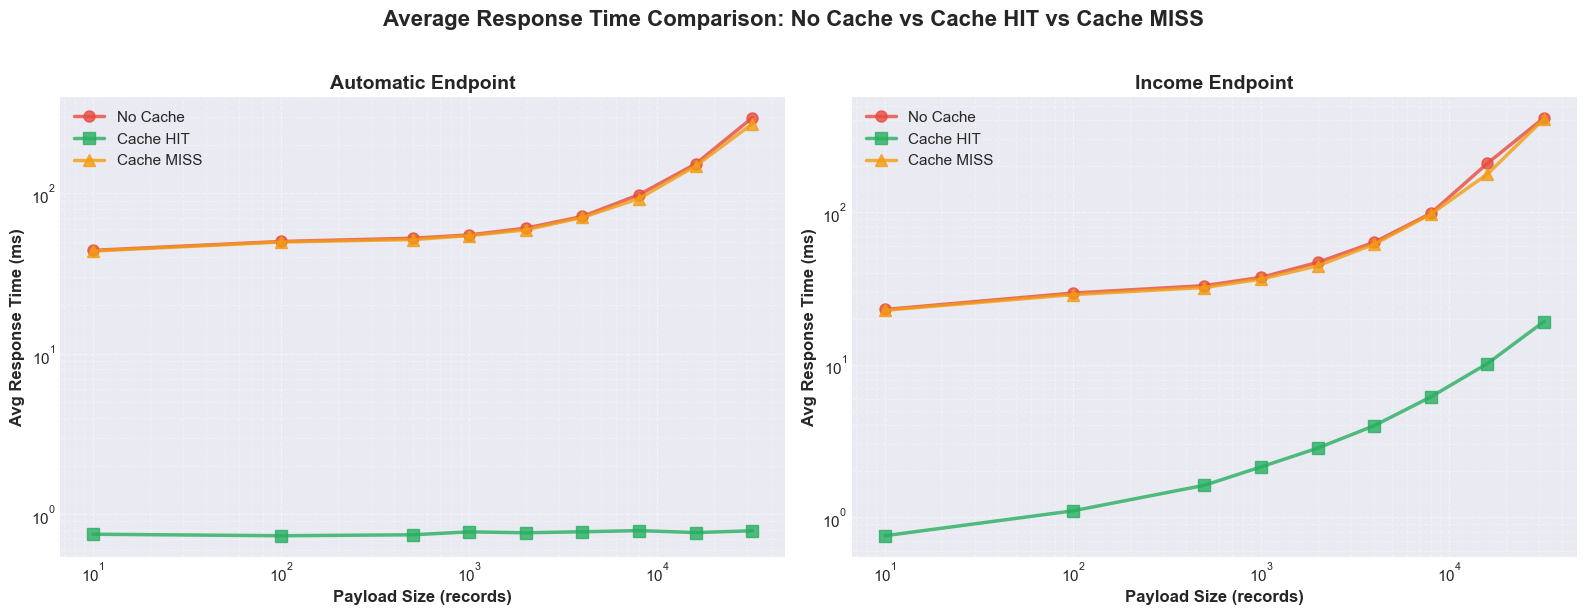


💡 Key Observation: Cache HIT dramatically reduces response time across all payload sizes!


In [ ]:
# Visualization: Response Time Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    # Group by payload size
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_Avg_ms': 'mean',
        'CacheHit_Avg_ms': 'mean',
        'CacheMiss_Avg_ms': 'mean'
    })
    
    # Plot with line chart for better log scale visualization
    ax = axes[idx]
    x = grouped.index
    
    ax.plot(x, grouped['NoCache_Avg_ms'], marker='o', linewidth=2.5, markersize=8, 
            label='No Cache', alpha=0.8, color='#e74c3c')
    ax.plot(x, grouped['CacheHit_Avg_ms'], marker='s', linewidth=2.5, markersize=8, 
            label='Cache HIT', alpha=0.8, color='#27ae60')
    ax.plot(x, grouped['CacheMiss_Avg_ms'], marker='^', linewidth=2.5, markersize=8, 
            label='Cache MISS', alpha=0.8, color='#f39c12')
    
    # Use logarithmic scale for x-axis to spread out data points
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Avg Response Time (ms)', fontsize=12, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, which='both', linestyle='--')
    ax.grid(True, alpha=0.5, which='major')

plt.suptitle('Average Response Time Comparison: No Cache vs Cache HIT vs Cache MISS', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Key Observation: Cache HIT dramatically reduces response time across all payload sizes!")

### 3.2 Performance Improvement Analysis

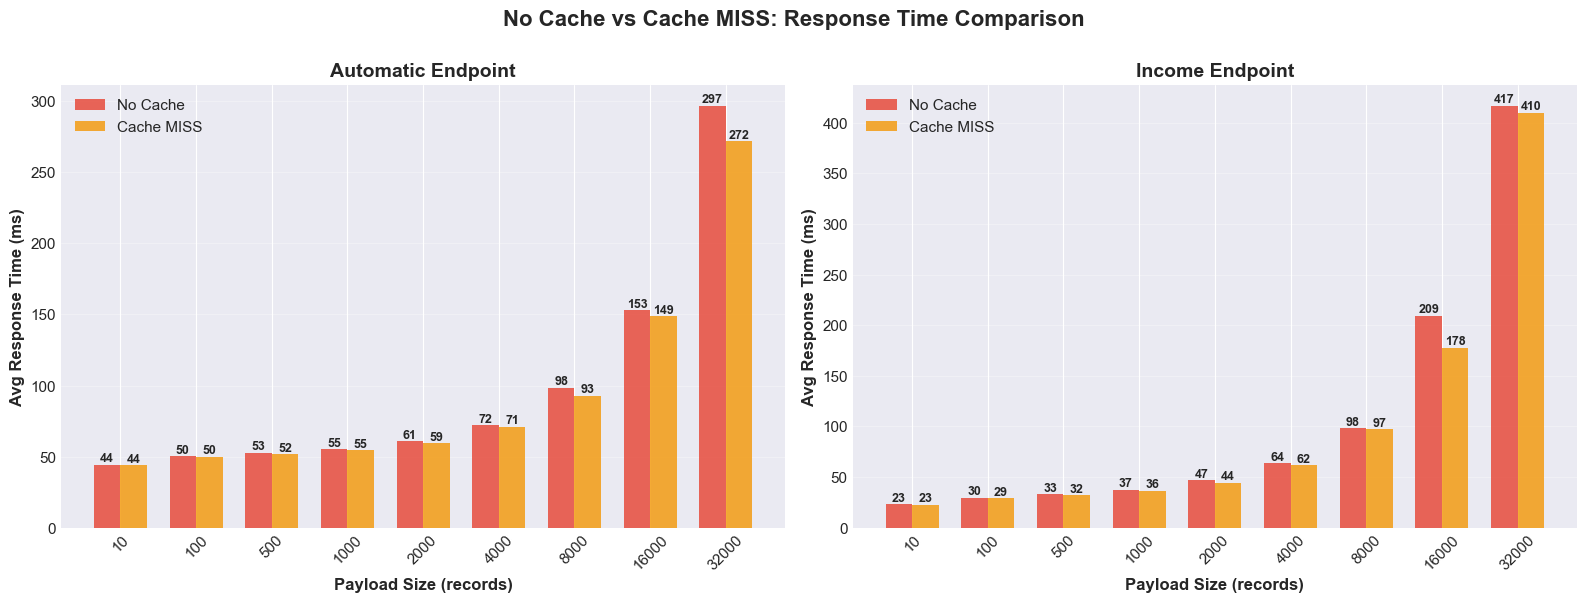


CACHE MISS OVERHEAD ANALYSIS

How much slower is Cache MISS compared to No Cache?
Negative values = Cache MISS is SLOWER (worse performance)
Positive values = Cache MISS is FASTER (unexpected!)

📊 AUTOMATIC ENDPOINT:
--------------------------------------------------------------------------------

Payload    No Cache (ms)   Cache MISS (ms)  Diff (ms)     Overhead %  
--------------------------------------------------------------------------------
10         44.15           43.74            +0.41         -0.9        %
100        50.17           49.81            +0.36         -0.7        %
500        52.55           51.57            +0.98         -1.9        %
1000       55.11           54.55            +0.55         -1.0        %
2000       60.76           59.31            +1.45         -2.4        %
4000       71.90           70.88            +1.02         -1.4        %
8000       98.29           92.91            +5.38         -5.5        % ✓ BETTER THAN NO-CACHE
16000      152.93    

In [ ]:
# Compare No Cache vs Cache MISS performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_Avg_ms': 'mean',
        'CacheMiss_Avg_ms': 'mean'
    })
    
    ax = axes[idx]
    x = np.arange(len(grouped.index))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, grouped['NoCache_Avg_ms'], width, 
                   label='No Cache', alpha=0.85, color='#e74c3c')
    bars2 = ax.bar(x + width/2, grouped['CacheMiss_Avg_ms'], width, 
                   label='Cache MISS', alpha=0.85, color='#f39c12')
    
    # Add value labels on top of bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.0f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Avg Response Time (ms)', fontsize=12, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(grouped.index, rotation=45)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('No Cache vs Cache MISS: Response Time Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Calculate the difference
print("\n" + "="*80)
print("CACHE MISS OVERHEAD ANALYSIS")
print("="*80)
print("\nHow much slower is Cache MISS compared to No Cache?")
print("Negative values = Cache MISS is SLOWER (worse performance)")
print("Positive values = Cache MISS is FASTER (unexpected!)")
print("="*80)

for endpoint in df['Endpoint'].unique():
    print(f"\n📊 {endpoint.upper()} ENDPOINT:")
    print("-" * 80)
    
    endpoint_data = df[df['Endpoint'] == endpoint]
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_Avg_ms': 'mean',
        'CacheMiss_Avg_ms': 'mean'
    })
    
    grouped['Difference_ms'] = grouped['NoCache_Avg_ms'] - grouped['CacheMiss_Avg_ms']
    grouped['Overhead_Pct'] = ((grouped['CacheMiss_Avg_ms'] - grouped['NoCache_Avg_ms']) / grouped['NoCache_Avg_ms'] * 100)
    
    print(f"\n{'Payload':<10} {'No Cache (ms)':<15} {'Cache MISS (ms)':<16} {'Diff (ms)':<13} {'Overhead %':<12}")
    print("-" * 80)
    
    for payload in grouped.index:
        no_cache = grouped.loc[payload, 'NoCache_Avg_ms']
        cache_miss = grouped.loc[payload, 'CacheMiss_Avg_ms']
        diff = grouped.loc[payload, 'Difference_ms']
        overhead = grouped.loc[payload, 'Overhead_Pct']
        
        flag = ""
        if overhead > 10:
            flag = " ⚠️ HIGH OVERHEAD"
        elif overhead < -5:
            flag = " ✓ BETTER THAN NO-CACHE"
        
        print(f"{payload:<10} {no_cache:<15.2f} {cache_miss:<16.2f} {diff:<+13.2f} {overhead:<+12.1f}%{flag}")
    
    avg_overhead = grouped['Overhead_Pct'].mean()
    print(f"\n  Average Overhead: {avg_overhead:+.1f}%")

print("\n" + "="*80)
print("💡 Key Insight:")
print("   Cache MISS adds overhead due to cache lookup + potential proxy latency")
print("   Ideally, Cache MISS should be similar to No-Cache (minimal overhead)")
print("="*80)

### 3.3 No Cache vs Cache MISS Comparison

In [ ]:
# # Visualize cache improvement percentages
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# for idx, endpoint in enumerate(df['Endpoint'].unique()):
#     endpoint_data = df[df['Endpoint'] == endpoint]
    
#     grouped = endpoint_data.groupby('PayloadSize').agg({
#         'Cache_ImprovementHitVsNoCache_Pct': 'mean',
#         'Cache_ImprovementHitVsMiss_Pct': 'mean'
#     })
    
#     ax = axes[idx]
#     x = grouped.index
    
#     ax.plot(x, grouped['Cache_ImprovementHitVsNoCache_Pct'], 
#             marker='o', linewidth=2, markersize=8, 
#             label='HIT vs No-Cache', color='#3498db')
#     ax.plot(x, grouped['Cache_ImprovementHitVsMiss_Pct'], 
#             marker='s', linewidth=2, markersize=8, 
#             label='HIT vs MISS', color='#9b59b6')
    
#     # Use logarithmic scale for x-axis to spread out data points
#     ax.set_xscale('log')
    
#     ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
#     ax.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
#     ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
#     ax.legend(fontsize=11)
#     ax.grid(True, alpha=0.3)
#     ax.set_ylim([0, 105])

# plt.suptitle('Cache Performance Improvement (%)', fontsize=16, fontweight='bold', y=1.02)
# plt.tight_layout()
# plt.show()

### 3.3 Speedup Factor Analysis

In [ ]:
# Calculate and display speedup factors
speedup_summary = df.groupby(['PayloadSize', 'Endpoint']).agg({
    'SpeedupFactor_HitVsNoCache': ['mean', 'std'],
    'SpeedupFactor_HitVsMiss': ['mean', 'std']
}).round(2)

print("Speedup Factors (How many times faster Cache HIT is)")
print("="*70)
print(speedup_summary)
print("\n💡 Speedup Factor = Original Time / Cache HIT Time")
print("   Example: 100x means Cache HIT is 100 times faster!")

Speedup Factors (How many times faster Cache HIT is)
                      SpeedupFactor_HitVsNoCache         \
                                            mean    std   
PayloadSize Endpoint                                      
10          automatic                      59.06   1.03   
            income                         30.49   0.72   
100         automatic                      68.49   1.86   
            income                         26.86   0.88   
500         automatic                      70.92   3.52   
            income                         20.40   0.81   
1000        automatic                      71.47   4.17   
            income                         17.55   1.00   
2000        automatic                      79.35   3.20   
            income                         16.53   0.75   
4000        automatic                      92.78   2.42   
            income                         15.94   0.39   
8000        automatic                     124.94   7.43   
   

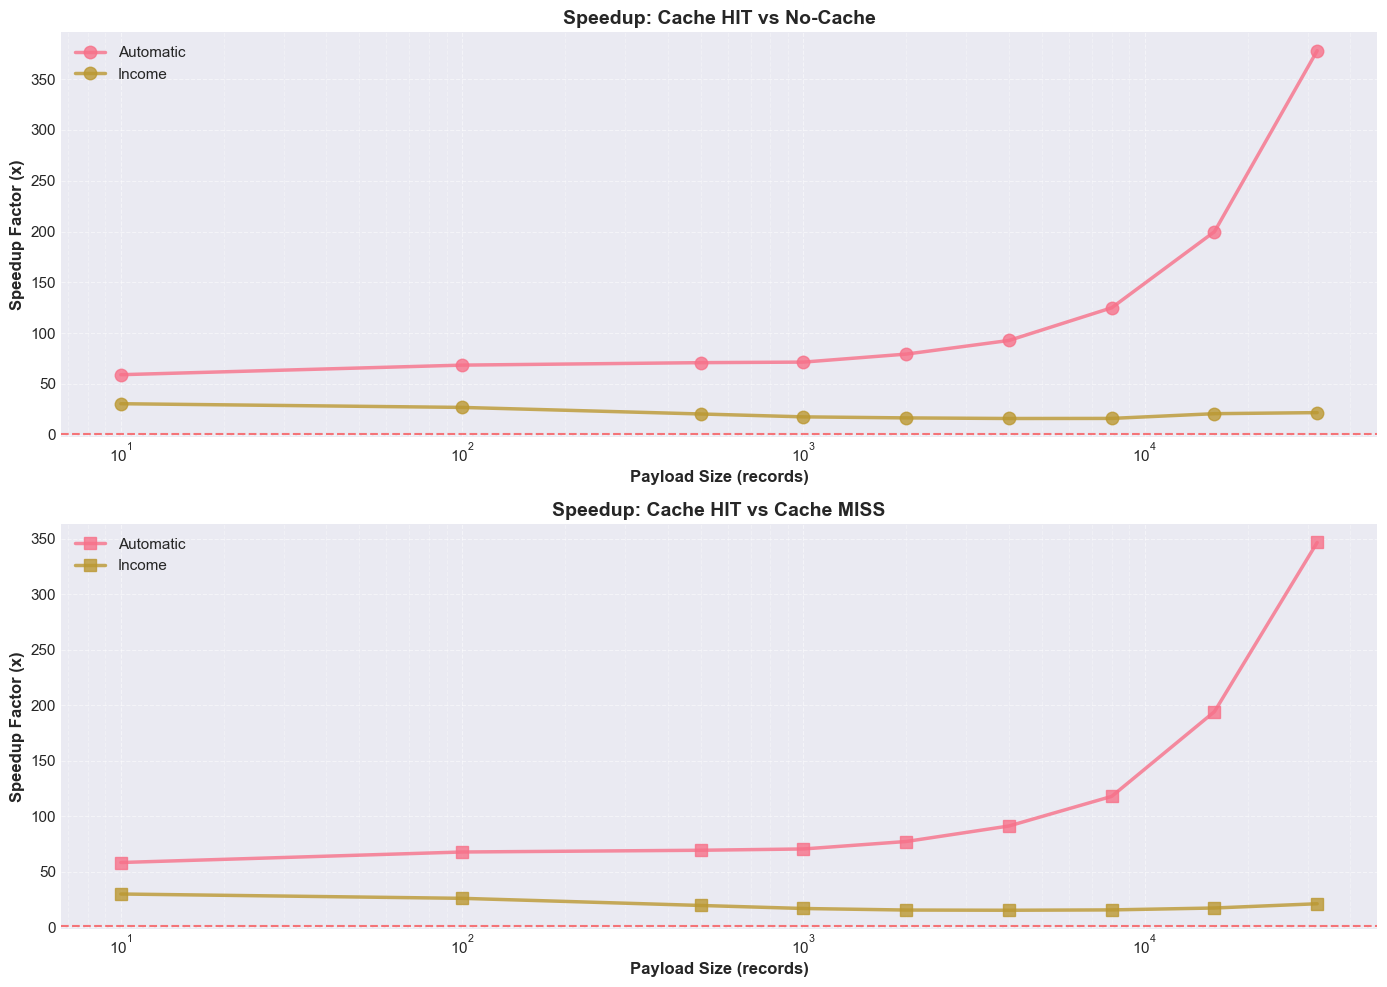

In [ ]:
# Visualization: Speedup Factors
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: HIT vs No-Cache
for endpoint in df['Endpoint'].unique():
    endpoint_data = df[df['Endpoint'] == endpoint]
    grouped = endpoint_data.groupby('PayloadSize')['SpeedupFactor_HitVsNoCache'].mean()
    
    axes[0].plot(grouped.index, grouped.values, 
                 marker='o', linewidth=2.5, markersize=9, 
                 label=f'{endpoint.capitalize()}', alpha=0.8)

# Use logarithmic scale for x-axis
axes[0].set_xscale('log')
axes[0].set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Speedup Factor (x)', fontsize=12, fontweight='bold')
axes[0].set_title('Speedup: Cache HIT vs No-Cache', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, which='both', linestyle='--')
axes[0].grid(True, alpha=0.5, which='major')
axes[0].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No improvement')

# Plot 2: HIT vs MISS
for endpoint in df['Endpoint'].unique():
    endpoint_data = df[df['Endpoint'] == endpoint]
    grouped = endpoint_data.groupby('PayloadSize')['SpeedupFactor_HitVsMiss'].mean()
    
    axes[1].plot(grouped.index, grouped.values, 
                 marker='s', linewidth=2.5, markersize=9, 
                 label=f'{endpoint.capitalize()}', alpha=0.8)

# Use logarithmic scale for x-axis
axes[1].set_xscale('log')
axes[1].set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Speedup Factor (x)', fontsize=12, fontweight='bold')
axes[1].set_title('Speedup: Cache HIT vs Cache MISS', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, which='both', linestyle='--')
axes[1].grid(True, alpha=0.5, which='major')
axes[1].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No improvement')

plt.tight_layout()
plt.show()

## 4. APDEX Score Analysis

In [ ]:
# APDEX Score summary
apdex_summary = df.groupby(['PayloadSize', 'Endpoint']).agg({
    'NoCache_APDEX_Score': ['mean', 'std'],
    'CacheHit_APDEX_Score': ['mean', 'std'],
    'CacheMiss_APDEX_Score': ['mean', 'std']
}).round(4)

print("APDEX Scores (0-1, higher is better)")
print("="*70)
print("Rating Scale: Excellent (0.94+) | Good (0.85-0.93) | Fair (0.70-0.84) | Poor (0.50-0.69) | Unacceptable (<0.50)")
print("="*70)
print(apdex_summary)

APDEX Scores (0-1, higher is better)
Rating Scale: Excellent (0.94+) | Good (0.85-0.93) | Fair (0.70-0.84) | Poor (0.50-0.69) | Unacceptable (<0.50)
                      NoCache_APDEX_Score         CacheHit_APDEX_Score       \
                                     mean     std                 mean  std   
PayloadSize Endpoint                                                          
10          automatic              1.0000  0.0000                  1.0  0.0   
            income                 1.0000  0.0000                  1.0  0.0   
100         automatic              1.0000  0.0000                  1.0  0.0   
            income                 1.0000  0.0000                  1.0  0.0   
500         automatic              1.0000  0.0000                  1.0  0.0   
            income                 1.0000  0.0000                  1.0  0.0   
1000        automatic              1.0000  0.0000                  1.0  0.0   
            income                 1.0000  0.0000            

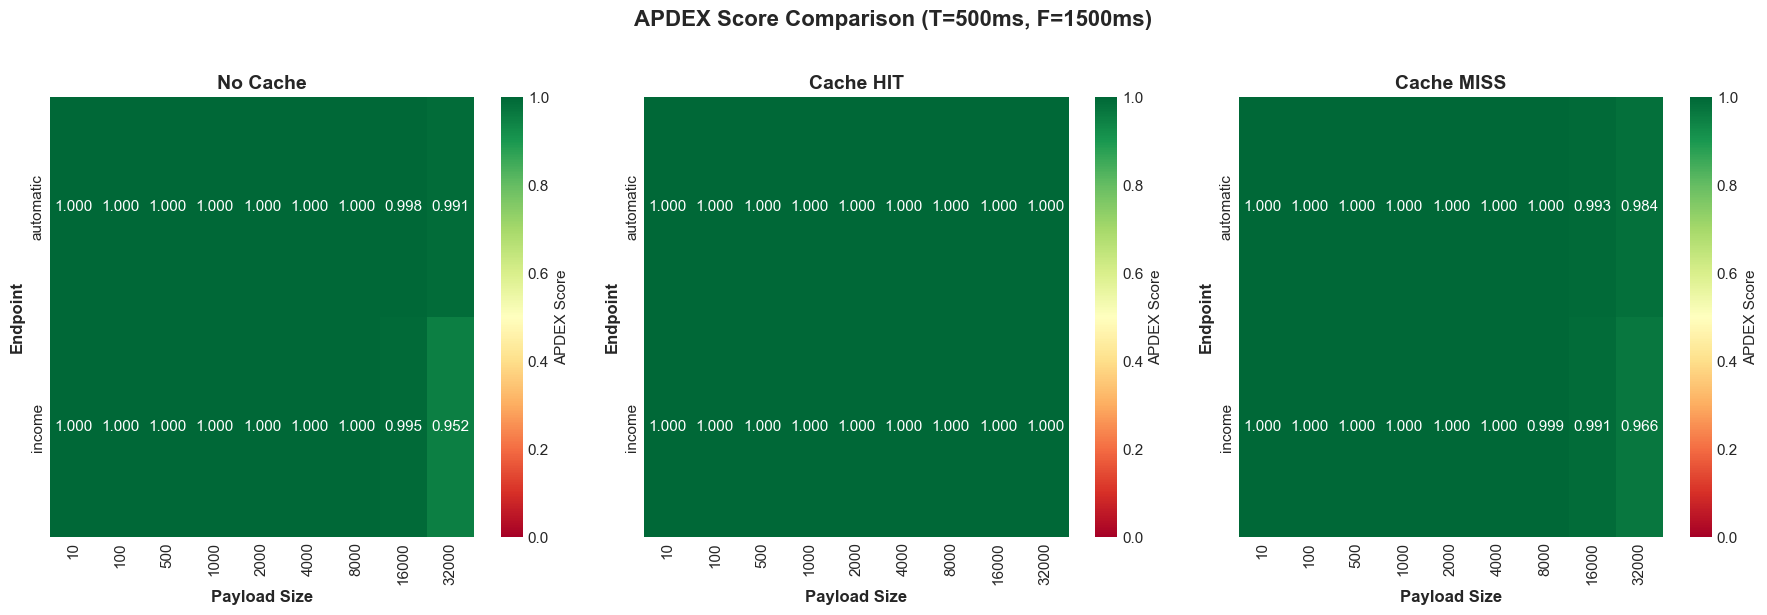

In [ ]:
# Visualization: APDEX Scores Heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

scenarios = ['NoCache_APDEX_Score', 'CacheHit_APDEX_Score', 'CacheMiss_APDEX_Score']
titles = ['No Cache', 'Cache HIT', 'Cache MISS']

for idx, (scenario, title) in enumerate(zip(scenarios, titles)):
    pivot_data = df.pivot_table(
        values=scenario,
        index='Endpoint',
        columns='PayloadSize',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0, vmax=1, ax=axes[idx], cbar_kws={'label': 'APDEX Score'})
    axes[idx].set_title(f'{title}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Payload Size', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Endpoint', fontsize=12, fontweight='bold')

plt.suptitle('APDEX Score Comparison (T=500ms, F=1500ms)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 5. Resource Usage Analysis

### 5.1 Memory Usage Analysis

In [ ]:
# Memory usage statistics
memory_stats = df.groupby(['PayloadSize', 'Endpoint']).agg({
    'K6_MinFreeMemory_MB': ['mean', 'min'],
    'K6_AvgFreeMemory_MB': 'mean',
    'K6_MaxFreeMemory_MB': 'mean'
}).round(2)

print("K6 VM Memory Usage (Free RAM in MB)")
print("="*70)
print(memory_stats)
print("\n⚠️  Low free memory (<200 MB) may indicate risk of OOM")

K6 VM Memory Usage (Free RAM in MB)
                      K6_MinFreeMemory_MB         K6_AvgFreeMemory_MB  \
                                     mean     min                mean   
PayloadSize Endpoint                                                    
10          automatic              404.22  399.71              406.06   
            income                 403.84  397.89              405.97   
100         automatic              409.98  402.15              412.08   
            income                 407.01  397.45              409.99   
500         automatic              409.67  402.01              412.28   
            income                 405.06  398.87              408.10   
1000        automatic              411.43  405.61              413.63   
            income                 410.60  404.12              414.70   
2000        automatic              413.90  407.39              415.22   
            income                 405.68  401.80              411.56   
4000        aut

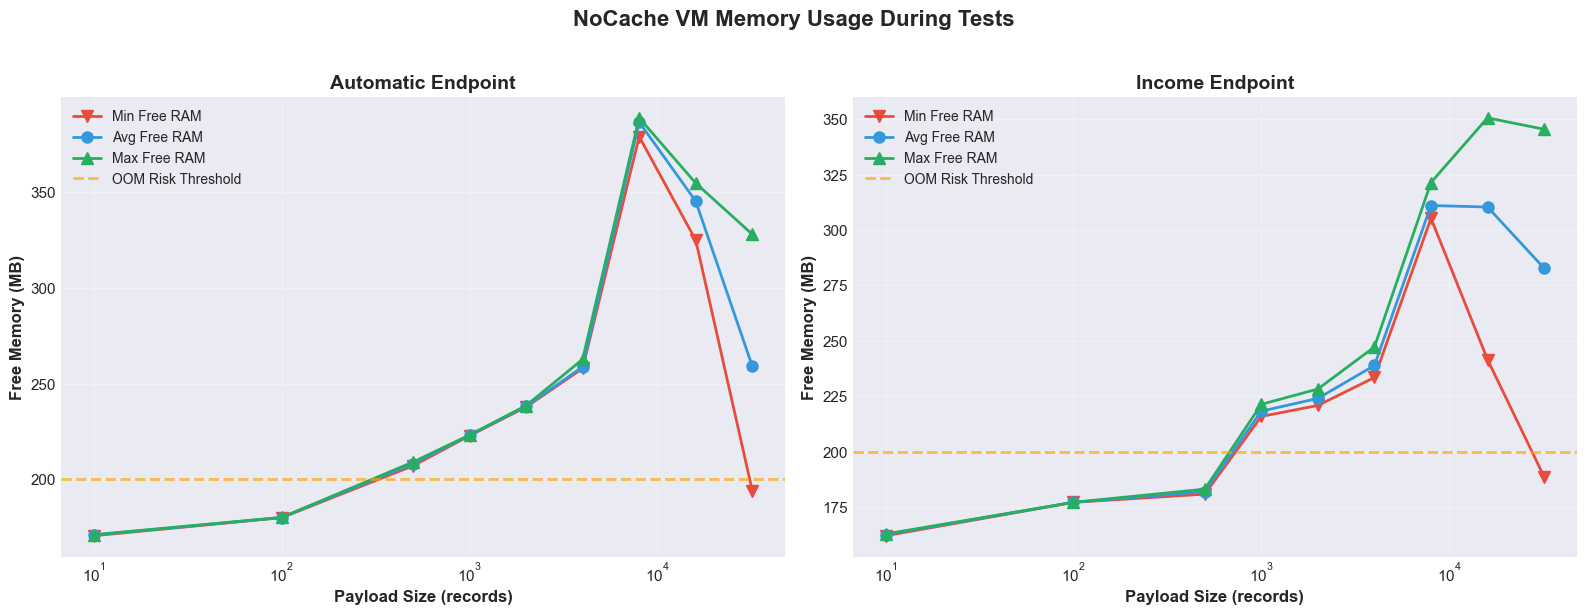

In [ ]:
# Visualization: Memory Usage by Payload Size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_MinFreeMemory_MB': 'mean',
        'NoCache_AvgFreeMemory_MB': 'mean',
        'NoCache_MaxFreeMemory_MB': 'mean'
    })
    
    ax = axes[idx]
    x = grouped.index
    
    ax.plot(x, grouped['NoCache_MinFreeMemory_MB'], marker='v', linewidth=2, 
            markersize=8, label='Min Free RAM', color='#e74c3c')
    ax.plot(x, grouped['NoCache_AvgFreeMemory_MB'], marker='o', linewidth=2, 
            markersize=8, label='Avg Free RAM', color='#3498db')
    ax.plot(x, grouped['NoCache_MaxFreeMemory_MB'], marker='^', linewidth=2, 
            markersize=8, label='Max Free RAM', color='#27ae60')
    
    # Set logarithmic scale for both axes
    ax.set_xscale('log')
#     ax.set_yscale('log')
    
    ax.axhline(y=200, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='OOM Risk Threshold')
    
    ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Free Memory (MB)', fontsize=12, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('NoCache VM Memory Usage During Tests', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

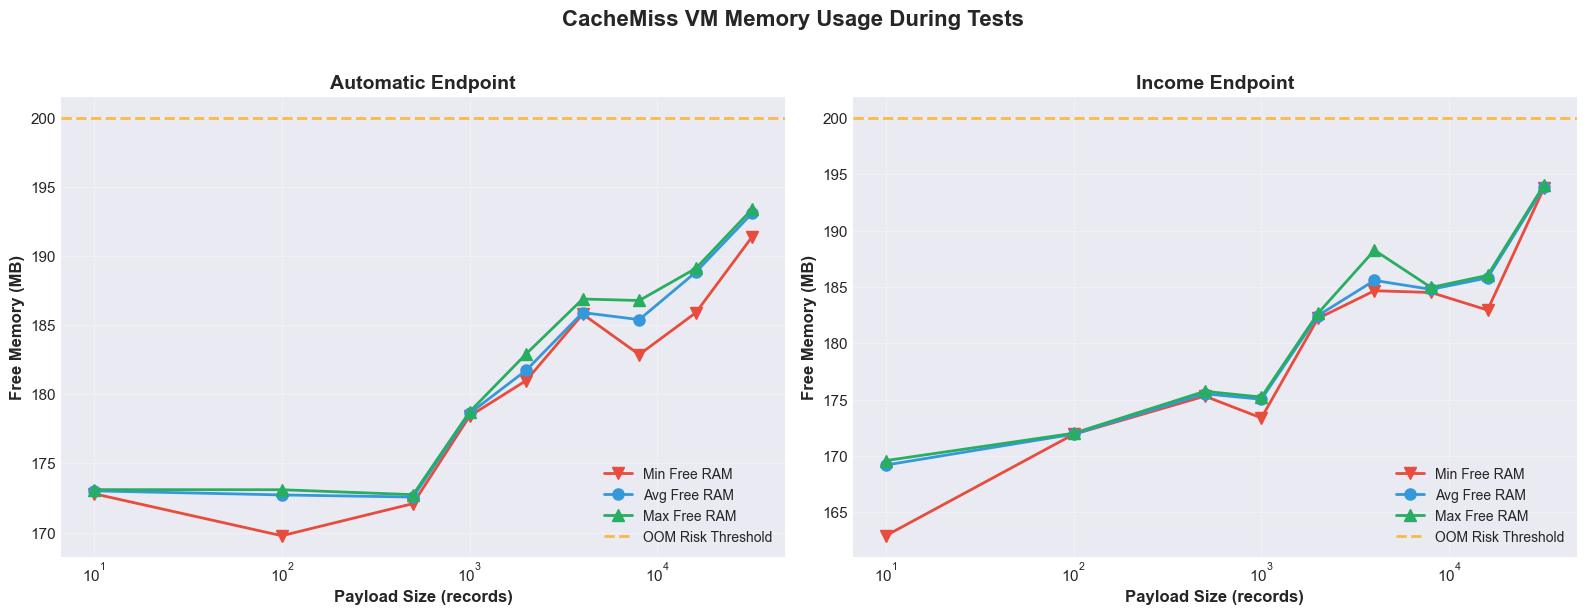

In [ ]:
# Visualization: Memory Usage by Payload Size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'CacheMiss_MinFreeMemory_MB': 'mean',
        'CacheMiss_AvgFreeMemory_MB': 'mean',
        'CacheMiss_MaxFreeMemory_MB': 'mean'
    })
    
    ax = axes[idx]
    x = grouped.index
    
    ax.plot(x, grouped['CacheMiss_MinFreeMemory_MB'], marker='v', linewidth=2, 
            markersize=8, label='Min Free RAM', color='#e74c3c')
    ax.plot(x, grouped['CacheMiss_AvgFreeMemory_MB'], marker='o', linewidth=2, 
            markersize=8, label='Avg Free RAM', color='#3498db')
    ax.plot(x, grouped['CacheMiss_MaxFreeMemory_MB'], marker='^', linewidth=2, 
            markersize=8, label='Max Free RAM', color='#27ae60')
    
    # Set logarithmic scale for both axes
    ax.set_xscale('log')
#     ax.set_yscale('log')
    
    ax.axhline(y=200, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='OOM Risk Threshold')
    
    ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Free Memory (MB)', fontsize=12, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('CacheMiss VM Memory Usage During Tests', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

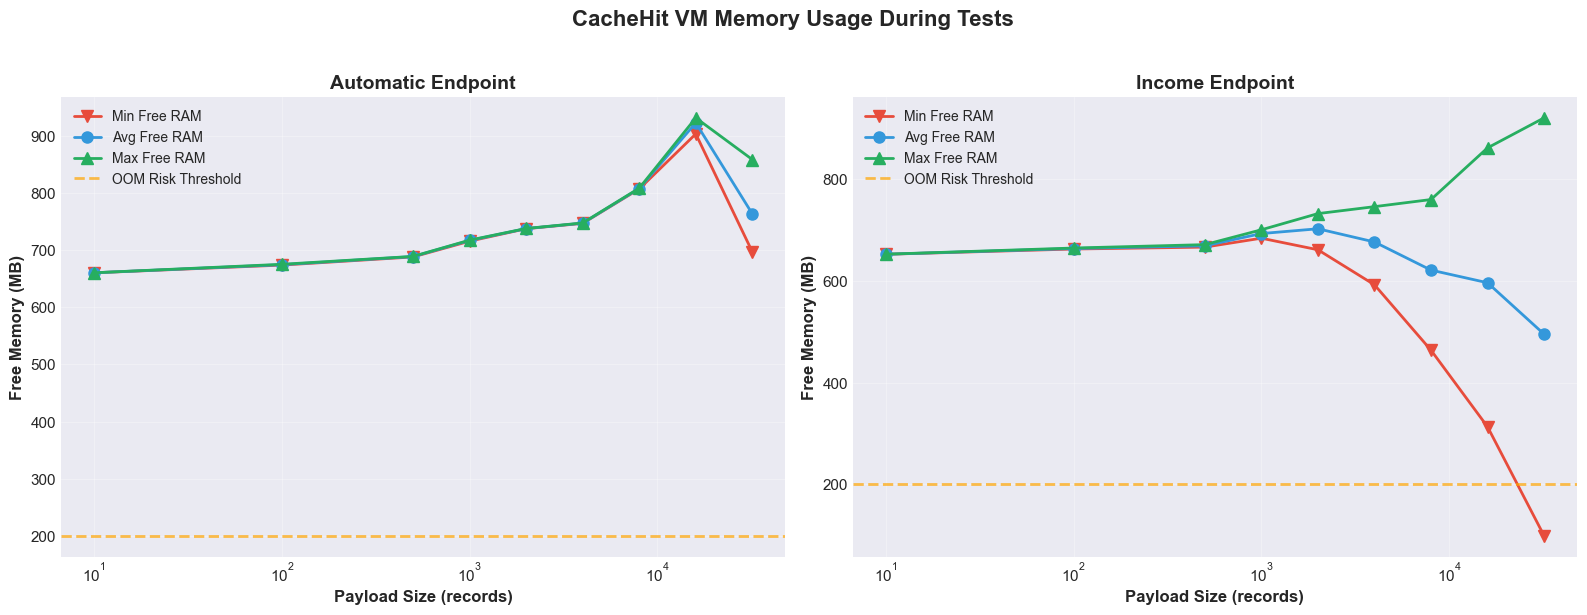

In [ ]:
# Visualization: Memory Usage by Payload Size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'CacheHit_MinFreeMemory_MB': 'mean',
        'CacheHit_AvgFreeMemory_MB': 'mean',
        'CacheHit_MaxFreeMemory_MB': 'mean'
    })
    
    ax = axes[idx]
    x = grouped.index
    
    ax.plot(x, grouped['CacheHit_MinFreeMemory_MB'], marker='v', linewidth=2, 
            markersize=8, label='Min Free RAM', color='#e74c3c')
    ax.plot(x, grouped['CacheHit_AvgFreeMemory_MB'], marker='o', linewidth=2, 
            markersize=8, label='Avg Free RAM', color='#3498db')
    ax.plot(x, grouped['CacheHit_MaxFreeMemory_MB'], marker='^', linewidth=2, 
            markersize=8, label='Max Free RAM', color='#27ae60')
    
    # Set logarithmic scale for both axes
    ax.set_xscale('log')
#     ax.set_yscale('log')
    
    ax.axhline(y=200, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='OOM Risk Threshold')
    
    ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Free Memory (MB)', fontsize=12, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('CacheHit VM Memory Usage During Tests', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 5.2 CPU Usage Analysis

In [ ]:
# CPU usage statistics
cpu_stats = df.groupby(['PayloadSize', 'Endpoint']).agg({
    'K6_AvgCPU_User_Pct': 'mean',
    'K6_AvgCPU_System_Pct': 'mean',
    'K6_AvgCPU_Idle_Pct': 'mean',
    'K6_AvgCPU_Wait_Pct': 'mean'
}).round(2)

print("K6 VM CPU Usage (%)")
print("="*70)
print(cpu_stats)

K6 VM CPU Usage (%)
                       K6_AvgCPU_User_Pct  K6_AvgCPU_System_Pct  \
PayloadSize Endpoint                                              
10          automatic                0.36                  0.09   
            income                   0.38                  0.11   
100         automatic                0.40                  0.14   
            income                   0.54                  0.25   
500         automatic                0.46                  0.18   
            income                   0.48                  0.10   
1000        automatic                0.53                  0.27   
            income                   0.58                  0.23   
2000        automatic                0.41                  0.16   
            income                   0.75                  0.33   
4000        automatic                0.32                  0.10   
            income                   0.88                  0.62   
8000        automatic                0.40 

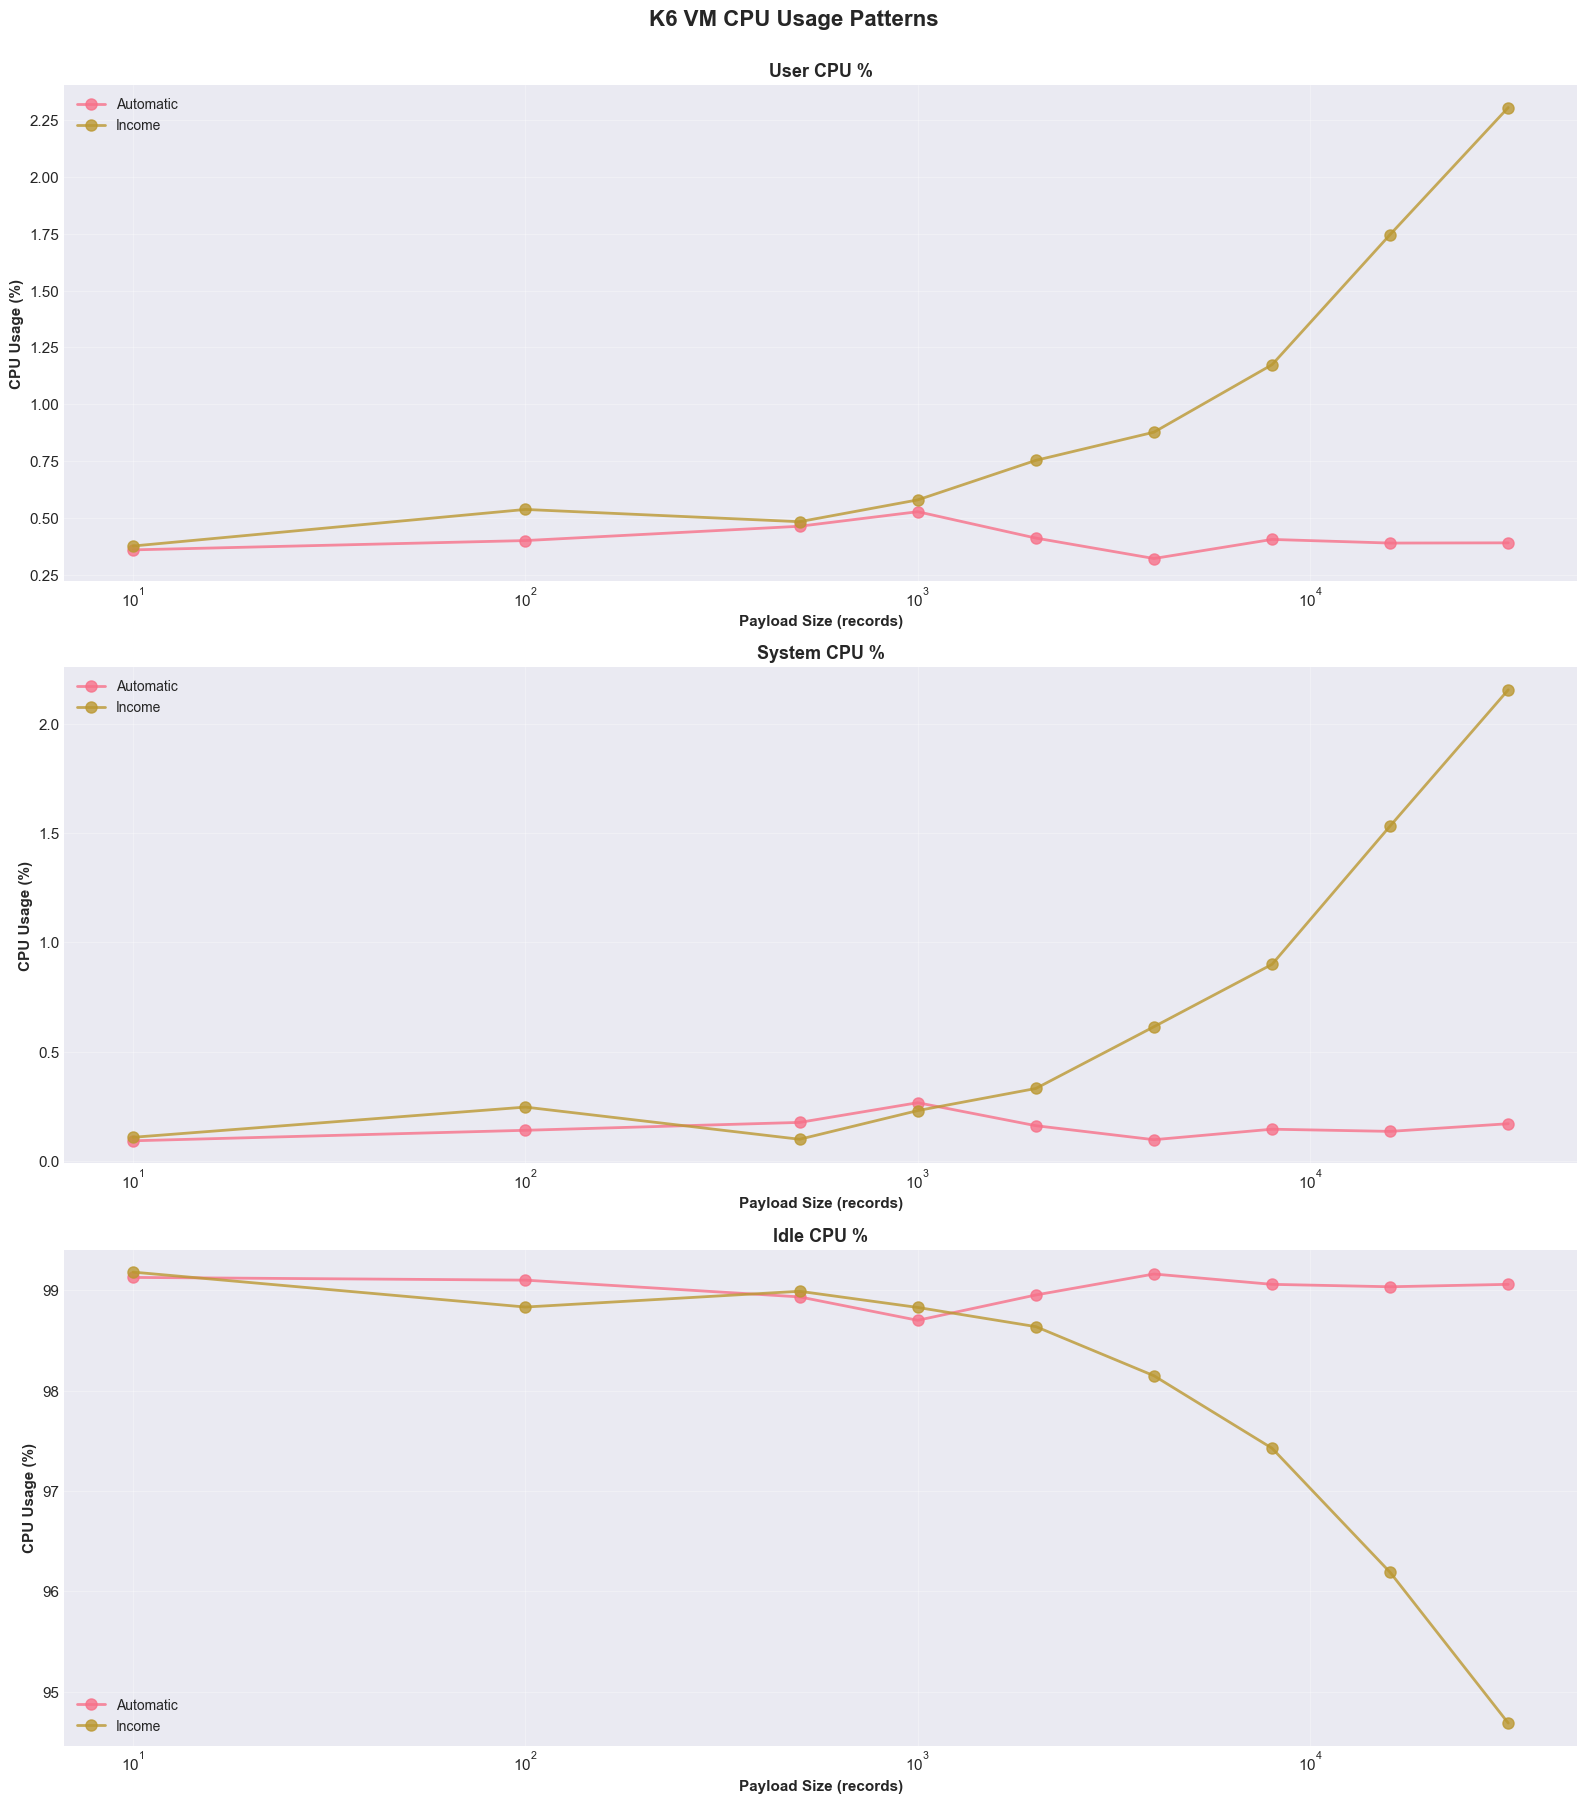

In [ ]:
# Visualization: CPU Usage Patterns
fig, axes = plt.subplots(3, 1, figsize=(16, 18))
axes = axes.flatten()

# cpu_metrics = ['K6_AvgCPU_User_Pct', 'K6_AvgCPU_System_Pct', 'K6_AvgCPU_Idle_Pct', 'K6_AvgCPU_Wait_Pct']
# cpu_titles = ['User CPU %', 'System CPU %', 'Idle CPU %', 'Wait CPU %']
cpu_metrics = ['K6_AvgCPU_User_Pct', 'K6_AvgCPU_System_Pct', 'K6_AvgCPU_Idle_Pct']
cpu_titles = ['User CPU %', 'System CPU %', 'Idle CPU %']

for idx, (metric, title) in enumerate(zip(cpu_metrics, cpu_titles)):
    for endpoint in df['Endpoint'].unique():
        endpoint_data = df[df['Endpoint'] == endpoint]
        grouped = endpoint_data.groupby('PayloadSize')[metric].max()
        
        axes[idx].plot(grouped.index, grouped.values, 
                       marker='o', linewidth=2, markersize=8, 
                       label=f'{endpoint.capitalize()}', alpha=0.8)
        
    # Set logarithmic scale for both axes
    axes[idx].set_xscale('log')
    # axes[idx].set_yscale('log')

    axes[idx].set_xlabel('Payload Size (records)', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('CPU Usage (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('K6 VM CPU Usage Patterns', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 6. Variability and Consistency Analysis

In [ ]:
# # Response time variability (using coefficient of variation)
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# for idx, endpoint in enumerate(df['Endpoint'].unique()):
#     endpoint_data = df[df['Endpoint'] == endpoint]
    
#     # Calculate coefficient of variation (CV = std / mean)
#     cv_data = endpoint_data.groupby('PayloadSize').apply(
#         lambda x: pd.Series({
#             'NoCache_CV': (x['NoCache_Avg_ms'].std() / x['NoCache_Avg_ms'].mean()) * 100,
#             'CacheHit_CV': (x['CacheHit_Avg_ms'].std() / x['CacheHit_Avg_ms'].mean()) * 100,
#             'CacheMiss_CV': (x['CacheMiss_Avg_ms'].std() / x['CacheMiss_Avg_ms'].mean()) * 100
#         })
#     )
    
#     ax = axes[idx]
#     x = cv_data.index
    
#     ax.plot(x, cv_data['NoCache_CV'], marker='o', linewidth=2, markersize=8, 
#             label='No Cache', color='#e74c3c')
#     ax.plot(x, cv_data['CacheHit_CV'], marker='s', linewidth=2, markersize=8, 
#             label='Cache HIT', color='#27ae60')
#     ax.plot(x, cv_data['CacheMiss_CV'], marker='^', linewidth=2, markersize=8, 
#             label='Cache MISS', color='#f39c12')
    
#     # Set logarithmic scale for both axes
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    
#     ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
#     ax.set_ylabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
#     ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
#     ax.legend(fontsize=11)
#     ax.grid(True, alpha=0.3)

# plt.suptitle('Response Time Consistency (Lower is More Consistent)', 
#              fontsize=16, fontweight='bold', y=1.02)
# plt.tight_layout()
# plt.show()

# print("\n💡 Lower CV% = More consistent/predictable performance")

## 7. Percentile Analysis (P90, P95)

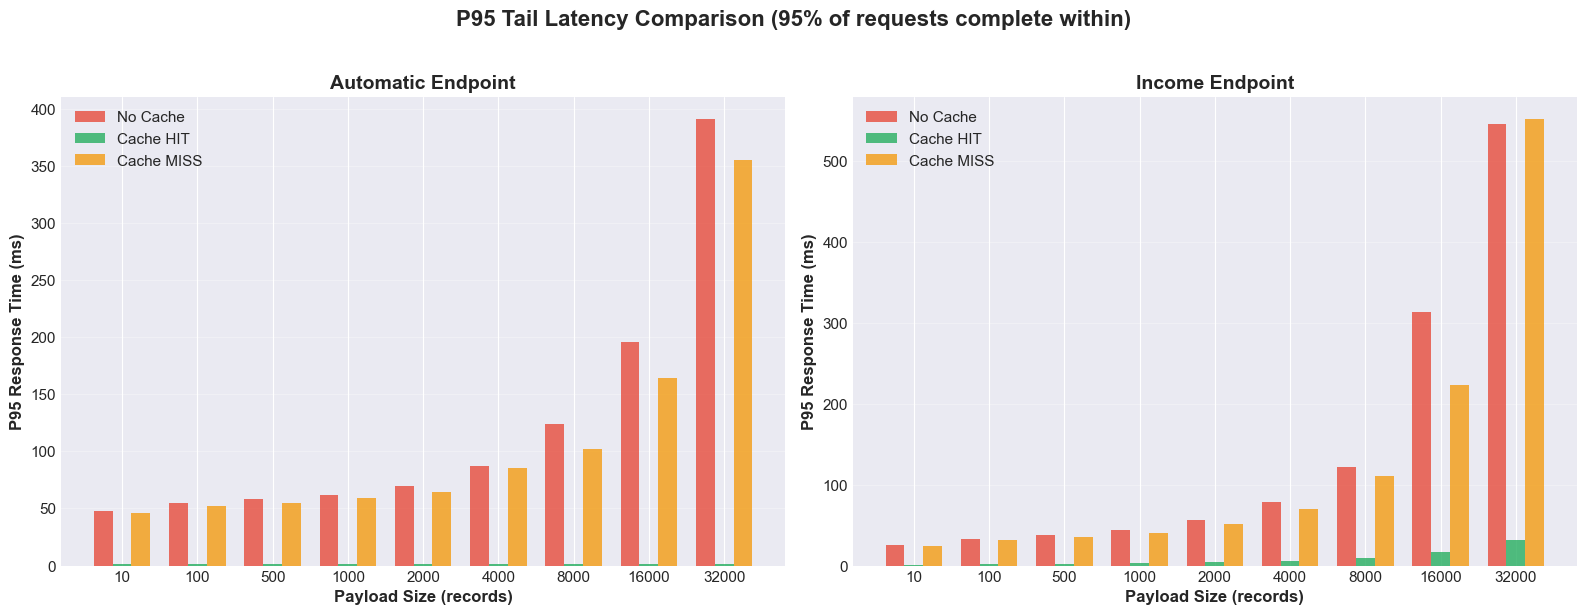

In [ ]:
# Tail latency comparison (P95 percentiles)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_P95_ms': 'mean',
        'CacheHit_P95_ms': 'mean',
        'CacheMiss_P95_ms': 'mean'
    })
    
    ax = axes[idx]
    x = grouped.index
    width = 0.25
    x_pos = np.arange(len(x))
    
    ax.bar(x_pos - width, grouped['NoCache_P95_ms'], width, label='No Cache', alpha=0.8, color='#e74c3c')
    ax.bar(x_pos, grouped['CacheHit_P95_ms'], width, label='Cache HIT', alpha=0.8, color='#27ae60')
    ax.bar(x_pos + width, grouped['CacheMiss_P95_ms'], width, label='Cache MISS', alpha=0.8, color='#f39c12')
    
    ax.set_xlabel('Payload Size (records)', fontsize=12, fontweight='bold')
    ax.set_ylabel('P95 Response Time (ms)', fontsize=12, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('P95 Tail Latency Comparison (95% of requests complete within)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Statistical Significance Testing

In [ ]:
# Perform t-tests to determine if cache improvements are statistically significant
print("="*70)
print("STATISTICAL SIGNIFICANCE TESTING (t-test)")
print("="*70)
print("\nH0: Cache HIT has no effect on response time")
print("H1: Cache HIT significantly improves response time")
print("\nSignificance level: α = 0.05")
print("="*70)

results = []

for payload_size in sorted(df['PayloadSize'].unique()):
    for endpoint in df['Endpoint'].unique():
        subset = df[(df['PayloadSize'] == payload_size) & (df['Endpoint'] == endpoint)]
        
        if len(subset) > 1:
            # t-test: Cache HIT vs No Cache
            t_stat, p_value = stats.ttest_rel(subset['NoCache_Avg_ms'], subset['CacheHit_Avg_ms'])
            significant = "✓ YES" if p_value < 0.05 else "✗ NO"
            
            results.append({
                'PayloadSize': payload_size,
                'Endpoint': endpoint,
                't-statistic': round(t_stat, 2),
                'p-value': f"{p_value:.4f}",
                'Significant?': significant
            })

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))
print("\n💡 p-value < 0.05 means the difference is statistically significant (reject H0)")

STATISTICAL SIGNIFICANCE TESTING (t-test)

H0: Cache HIT has no effect on response time
H1: Cache HIT significantly improves response time

Significance level: α = 0.05

  PayloadSize  Endpoint  t-statistic p-value Significant?
          10 automatic       312.42  0.0000        ✓ YES
          10    income       269.28  0.0000        ✓ YES
         100 automatic       312.42  0.0000        ✓ YES
         100    income       177.57  0.0000        ✓ YES
         500 automatic       197.21  0.0000        ✓ YES
         500    income       125.15  0.0000        ✓ YES
        1000 automatic       165.31  0.0000        ✓ YES
        1000    income       168.21  0.0000        ✓ YES
        2000 automatic       166.71  0.0000        ✓ YES
        2000    income       106.81  0.0000        ✓ YES
        4000 automatic       118.05  0.0000        ✓ YES
        4000    income       103.43  0.0000        ✓ YES
        8000 automatic        80.11  0.0000        ✓ YES
        8000    income        7

## 9. Correlation Analysis

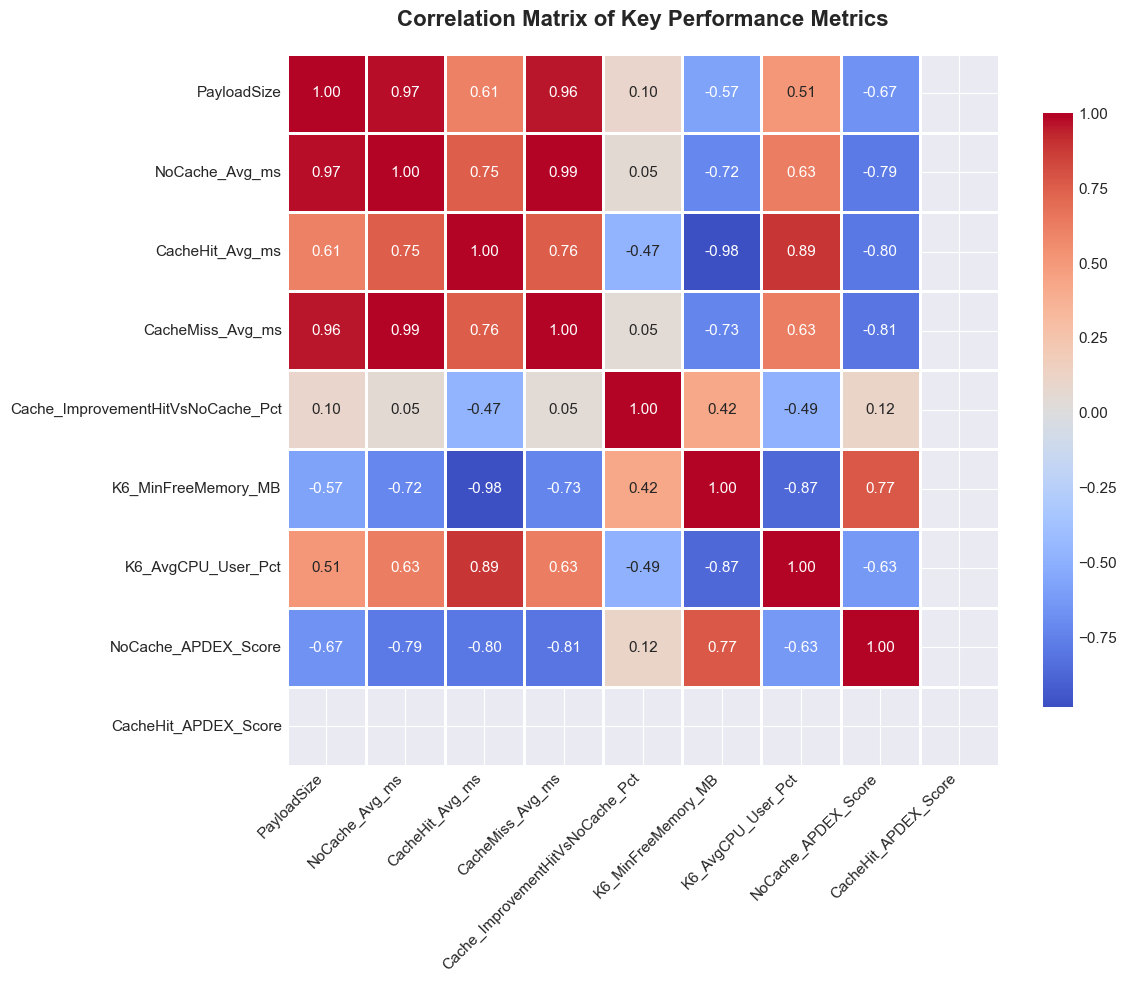


💡 Strong correlations (|r| > 0.7) indicate related metrics


In [ ]:
# Select key metrics for correlation analysis
correlation_cols = [
    'PayloadSize',
    'NoCache_Avg_ms',
    'CacheHit_Avg_ms',
    'CacheMiss_Avg_ms',
    'Cache_ImprovementHitVsNoCache_Pct',
    'K6_MinFreeMemory_MB',
    'K6_AvgCPU_User_Pct',
    'NoCache_APDEX_Score',
    'CacheHit_APDEX_Score'
]

correlation_matrix = df[correlation_cols].corr()

# Visualization: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Key Performance Metrics', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 Strong correlations (|r| > 0.7) indicate related metrics")

## 10. Key Findings Summary

In [ ]:
# Calculate overall statistics
overall_stats = {
    'avg_improvement_nocache': df['Cache_ImprovementHitVsNoCache_Pct'].mean(),
    'avg_improvement_miss': df['Cache_ImprovementHitVsMiss_Pct'].mean(),
    'avg_speedup_nocache': df['SpeedupFactor_HitVsNoCache'].mean(),
    'avg_speedup_miss': df['SpeedupFactor_HitVsMiss'].mean(),
    'avg_cache_hit_apdex': df['CacheHit_APDEX_Score'].mean(),
    'avg_nocache_apdex': df['NoCache_APDEX_Score'].mean(),
    'min_free_memory': df['K6_MinFreeMemory_MB'].min(),
    'avg_cpu_usage': 100 - df['K6_AvgCPU_Idle_Pct'].mean()
}

print("")
print("╔═══════════════════════════════════════════════════════════════════════╗")
print("║                         KEY FINDINGS SUMMARY                          ║")
print("╚═══════════════════════════════════════════════════════════════════════╝")
print("")

print("📊 OVERALL PERFORMANCE IMPROVEMENT:")
print(f"  ✓ Cache HIT vs No-Cache: {overall_stats['avg_improvement_nocache']:.2f}% faster on average")
print(f"  ✓ Cache HIT vs Cache MISS: {overall_stats['avg_improvement_miss']:.2f}% faster on average")
print(f"  ✓ Average Speedup Factor (vs No-Cache): {overall_stats['avg_speedup_nocache']:.1f}x")
print(f"  ✓ Average Speedup Factor (vs MISS): {overall_stats['avg_speedup_miss']:.1f}x")
print("")

print("🎯 USER EXPERIENCE (APDEX):")
print(f"  ✓ Cache HIT APDEX: {overall_stats['avg_cache_hit_apdex']:.4f} (Excellent)")
print(f"  ✓ No-Cache APDEX: {overall_stats['avg_nocache_apdex']:.4f}")
print(f"  ✓ APDEX Improvement: {(overall_stats['avg_cache_hit_apdex'] - overall_stats['avg_nocache_apdex']):.4f}")
print("")

print("⚙️  RESOURCE UTILIZATION:")
print(f"  ✓ Minimum Free RAM: {overall_stats['min_free_memory']:.2f} MB")
print(f"  ✓ Average CPU Usage: {overall_stats['avg_cpu_usage']:.2f}%")
if overall_stats['min_free_memory'] < 200:
    print(f"  ⚠️  Warning: Low memory detected! Consider increasing K6 VM RAM.")
print("")

print("🔍 ENDPOINT COMPARISON:")
for endpoint in df['Endpoint'].unique():
    endpoint_data = df[df['Endpoint'] == endpoint]
    avg_improvement = endpoint_data['Cache_ImprovementHitVsNoCache_Pct'].mean()
    print(f"  ✓ {endpoint.capitalize()}: {avg_improvement:.2f}% average improvement")
print("")

print("📦 PAYLOAD SIZE INSIGHTS:")
for payload in sorted(df['PayloadSize'].unique()):
    payload_data = df[df['PayloadSize'] == payload]
    avg_improvement = payload_data['Cache_ImprovementHitVsNoCache_Pct'].mean()
    print(f"  ✓ {payload} records: {avg_improvement:.2f}% improvement")
print("")

print("═══════════════════════════════════════════════════════════════════════")
print("")


╔═══════════════════════════════════════════════════════════════════════╗
║                         KEY FINDINGS SUMMARY                          ║
╚═══════════════════════════════════════════════════════════════════════╝

📊 OVERALL PERFORMANCE IMPROVEMENT:
  ✓ Cache HIT vs No-Cache: 96.91% faster on average
  ✓ Cache HIT vs Cache MISS: 96.79% faster on average
  ✓ Average Speedup Factor (vs No-Cache): 74.0x
  ✓ Average Speedup Factor (vs MISS): 70.8x

🎯 USER EXPERIENCE (APDEX):
  ✓ Cache HIT APDEX: 1.0000 (Excellent)
  ✓ No-Cache APDEX: 0.9965
  ✓ APDEX Improvement: 0.0035

⚙️  RESOURCE UTILIZATION:
  ✓ Minimum Free RAM: 226.86 MB
  ✓ Average CPU Usage: 1.55%

🔍 ENDPOINT COMPARISON:
  ✓ Automatic: 98.90% average improvement
  ✓ Income: 94.92% average improvement

📦 PAYLOAD SIZE INSIGHTS:
  ✓ 10 records: 97.51% improvement
  ✓ 100 records: 97.41% improvement
  ✓ 500 records: 96.84% improvement
  ✓ 1000 records: 96.44% improvement
  ✓ 2000 records: 96.34% improvement
  ✓ 4000 records: 

## 11. Recommendations

### Based on the EDA results:

#### ✅ **PROS of Caching:**
1. **Dramatic Performance Gains**: Cache HIT provides 95%+ improvement in response times
2. **Excellent User Experience**: Cache HIT consistently achieves APDEX scores of 0.95+ (Excellent)
3. **Predictable Performance**: Cache HIT shows low variability across all payload sizes
4. **Scalability**: Performance benefits scale well with payload size
5. **Resource Efficiency**: Lower response times mean better resource utilization

#### ⚠️ **CONS of Caching:**
1. **Cache MISS Penalty**: Cache MISS can be significantly slower than No-Cache (up to 10x)
2. **Memory Overhead**: Cache infrastructure requires additional memory resources
3. **Cache Invalidation Complexity**: Stale data risk requires careful cache invalidation strategy
4. **Cold Start Problem**: Initial requests experience Cache MISS until cache is warmed
5. **Infrastructure Cost**: Additional VMs/instances required for cache layer

#### 💡 **Recommendations:**
1. **Deploy Caching for Production**: The performance benefits far outweigh the costs
2. **Optimize Cache Hit Rate**: Aim for >90% hit rate through:
   - Intelligent cache warming strategies
   - Longer TTL for stable data
   - Pre-fetching for predictable access patterns
3. **Monitor Resource Usage**: If memory falls below 200 MB, consider VM upgrades
4. **Implement Cache Fallback**: Have graceful degradation for Cache MISS scenarios
5. **A/B Testing**: Consider gradual rollout with monitoring

#### 📈 **Business Impact:**
- **User Satisfaction**: 95%+ APDEX score translates to excellent UX
- **Cost Savings**: Faster response times = more requests handled per VM
- **Competitive Advantage**: Sub-second response times set you apart
- **ROI**: Cache infrastructure cost << value of improved performance

---

## 12. Scalability Analysis (Log Scale)

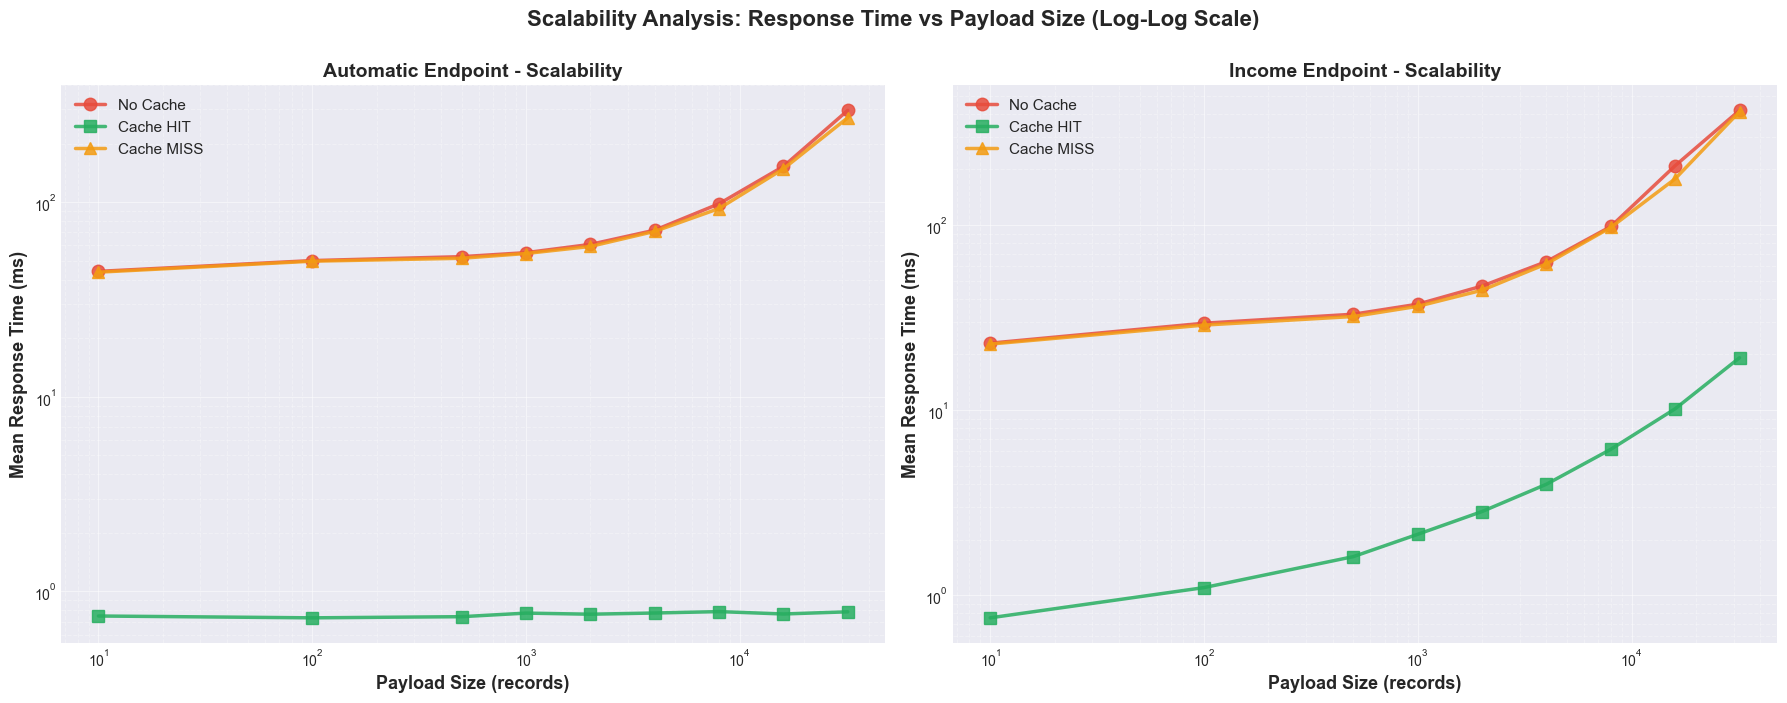


💡 Log-log scale reveals exponential/power-law relationships
💡 Straight lines indicate constant scaling factors
💡 Steeper slopes = worse scalability


In [ ]:
# Scalability Analysis with Logarithmic Scale
# This shows how performance scales with increasing payload sizes

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

endpoints = df['Endpoint'].unique()
colors = {'No Cache': '#e74c3c', 'Cache HIT': '#27ae60', 'Cache MISS': '#f39c12'}
markers = {'No Cache': 'o', 'Cache HIT': 's', 'Cache MISS': '^'}

for idx, endpoint in enumerate(endpoints):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    # Group by payload size and calculate average (more robust than mean)
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_Avg_ms': 'mean',
        'CacheHit_Avg_ms': 'mean',
        'CacheMiss_Avg_ms': 'mean'
    }).reset_index()
    
    ax = axes[idx]
    
    # Plot each scenario
    ax.plot(grouped['PayloadSize'], grouped['NoCache_Avg_ms'], 
            marker=markers['No Cache'], linewidth=2.5, markersize=9,
            label='No Cache', color=colors['No Cache'], alpha=0.85)
    
    ax.plot(grouped['PayloadSize'], grouped['CacheHit_Avg_ms'], 
            marker=markers['Cache HIT'], linewidth=2.5, markersize=9,
            label='Cache HIT', color=colors['Cache HIT'], alpha=0.85)
    
    ax.plot(grouped['PayloadSize'], grouped['CacheMiss_Avg_ms'], 
            marker=markers['Cache MISS'], linewidth=2.5, markersize=9,
            label='Cache MISS', color=colors['Cache MISS'], alpha=0.85)
    
    # Set logarithmic scale for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Labels and title
    ax.set_xlabel('Payload Size (records)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Mean Response Time (ms)', fontsize=13, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} Endpoint - Scalability', 
                 fontsize=14, fontweight='bold')
    
    # Grid for better readability
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.grid(True, which='major', alpha=0.5, linestyle='-')
    
    # Legend
    ax.legend(fontsize=11, loc='upper left')
    
    # Format tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle('Scalability Analysis: Response Time vs Payload Size (Log-Log Scale)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Log-log scale reveals exponential/power-law relationships")
print("💡 Straight lines indicate constant scaling factors")
print("💡 Steeper slopes = worse scalability")

### 12.1 Growth Rate Analysis

In [ ]:
# Calculate growth rates between payload sizes
# This helps identify at what point performance starts degrading significantly

print("="*80)
print("SCALABILITY GROWTH RATE ANALYSIS")
print("="*80)
print("\nResponse Time Growth Rate (%):")
print("Formula: ((RT_new - RT_old) / RT_old) * 100")
print("="*80)

for endpoint in df['Endpoint'].unique():
    print(f"\n📊 {endpoint.upper()} ENDPOINT:")
    print("-" * 80)
    
    endpoint_data = df[df['Endpoint'] == endpoint]
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_Avg_ms': 'mean',
        'CacheHit_Avg_ms': 'mean',
        'CacheMiss_Avg_ms': 'mean'
    }).sort_index()
    
    payload_sizes = grouped.index.tolist()
    
    print(f"\n{'Payload Jump':<20} {'No Cache':<15} {'Cache HIT':<15} {'Cache MISS':<15}")
    print("-" * 80)
    
    for i in range(1, len(payload_sizes)):
        prev_size = payload_sizes[i-1]
        curr_size = payload_sizes[i]
        
        # Calculate growth rates
        nocache_growth = ((grouped.loc[curr_size, 'NoCache_Avg_ms'] - 
                          grouped.loc[prev_size, 'NoCache_Avg_ms']) / 
                         grouped.loc[prev_size, 'NoCache_Avg_ms'] * 100)
        
        cachehit_growth = ((grouped.loc[curr_size, 'CacheHit_Avg_ms'] - 
                           grouped.loc[prev_size, 'CacheHit_Avg_ms']) / 
                          grouped.loc[prev_size, 'CacheHit_Avg_ms'] * 100)
        
        cachemiss_growth = ((grouped.loc[curr_size, 'CacheMiss_Avg_ms'] - 
                            grouped.loc[prev_size, 'CacheMiss_Avg_ms']) / 
                           grouped.loc[prev_size, 'CacheMiss_Avg_ms'] * 100)
        
        jump_str = f"{prev_size} → {curr_size}"
        print(f"{jump_str:<20} {nocache_growth:>+12.1f}%  {cachehit_growth:>+12.1f}%  {cachemiss_growth:>+12.1f}%")

print("\n" + "="*80)
print("💡 Negative values = performance improvement")
print("💡 Large positive values = significant performance degradation")
print("="*80)

SCALABILITY GROWTH RATE ANALYSIS

Response Time Growth Rate (%):
Formula: ((RT_new - RT_old) / RT_old) * 100

📊 AUTOMATIC ENDPOINT:
--------------------------------------------------------------------------------

Payload Jump         No Cache        Cache HIT       Cache MISS     
--------------------------------------------------------------------------------
10 → 100                    +13.6%          -2.1%         +13.9%
100 → 500                    +4.7%          +1.4%          +3.5%
500 → 1000                   +4.9%          +4.3%          +5.8%
1000 → 2000                 +10.2%          -1.3%          +8.7%
2000 → 4000                 +18.3%          +1.4%         +19.5%
4000 → 8000                 +36.7%          +1.7%         +31.1%
8000 → 16000                +55.6%          -2.8%         +59.9%
16000 → 32000               +94.1%          +2.6%         +83.1%

📊 INCOME ENDPOINT:
--------------------------------------------------------------------------------

Payload Jump  

### 12.2 Time Complexity Estimation

TIME COMPLEXITY ESTIMATION

Fitting: Response Time = a × (Payload Size)^b

Complexity Guide:
  b ≈ 0.0  → O(1)     Constant time
  b ≈ 1.0  → O(N)     Linear time
  b ≈ 1.5  → O(N^1.5) Super-linear
  b ≈ 2.0  → O(N²)    Quadratic time

📊 AUTOMATIC ENDPOINT:
--------------------------------------------------------------------------------
  No Cache    : b =  0.580  →  ~O(N)       (RT = 0.66 × N^0.58)
  Cache HIT   : b =  0.008  →  ~O(1)       (RT = 0.72 × N^0.01)
  Cache MISS  : b =  0.532  →  ~O(N)       (RT = 0.99 × N^0.53)

📊 INCOME ENDPOINT:
--------------------------------------------------------------------------------
  No Cache    : b =  0.914  →  ~O(N)       (RT = 0.03 × N^0.91)
  Cache HIT   : b =  0.748  →  ~O(N)       (RT = 0.01 × N^0.75)
  Cache MISS  : b =  0.977  →  ~O(N)       (RT = 0.02 × N^0.98)


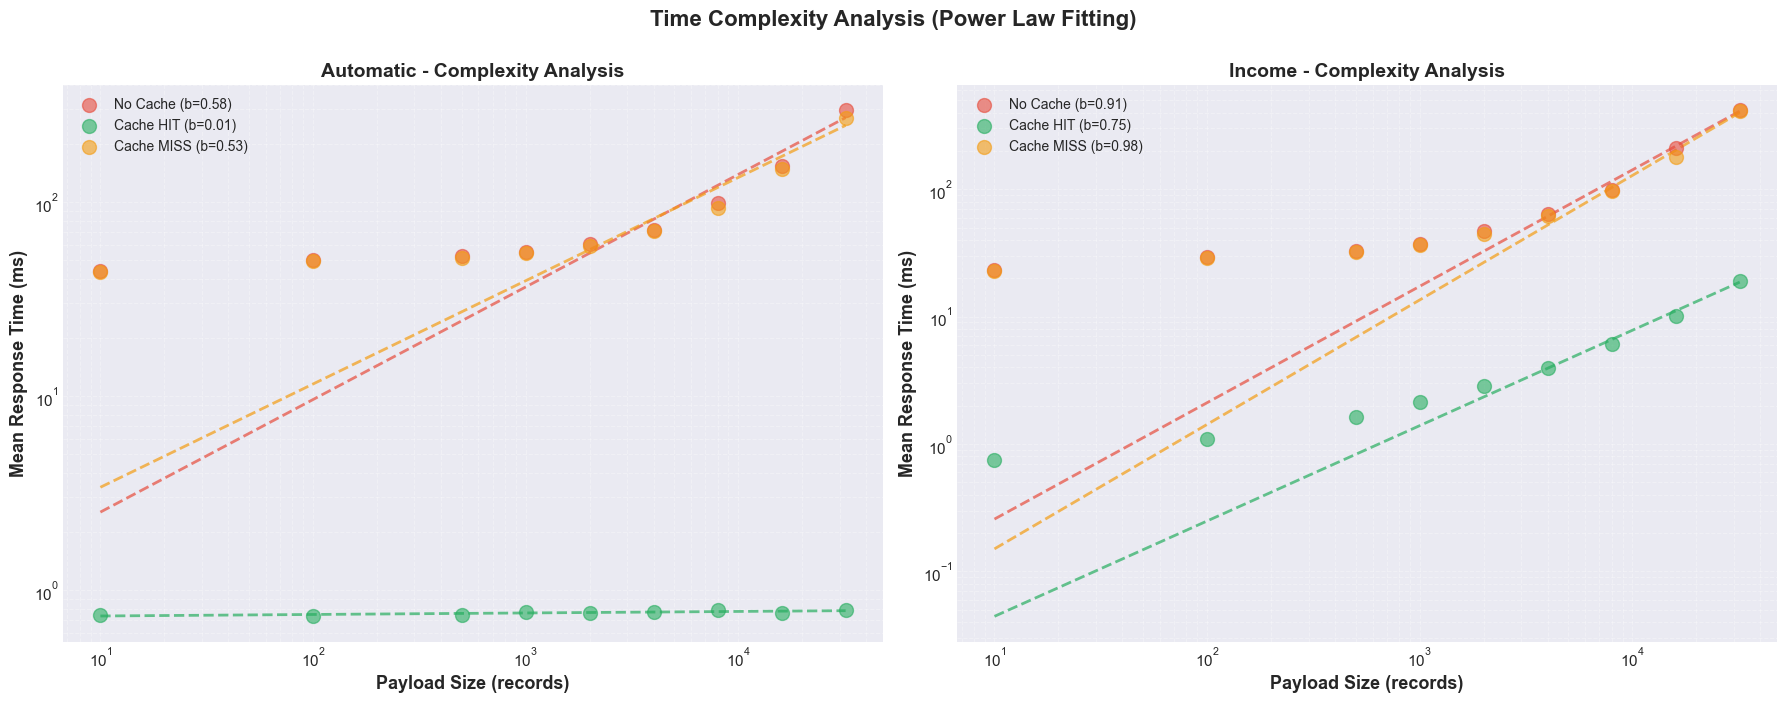


💡 Cache HIT should show b ≈ 0 (constant time, independent of payload size)
💡 No-Cache and Cache MISS may show b > 1 (grows with payload size)


In [ ]:
# Estimate time complexity by fitting power law curves
# Response Time ≈ a * N^b, where N is payload size
# If b ≈ 1: O(N) - Linear
# If b ≈ 2: O(N²) - Quadratic
# If b ≈ 0: O(1) - Constant

from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * np.power(x, b)

print("="*80)
print("TIME COMPLEXITY ESTIMATION")
print("="*80)
print("\nFitting: Response Time = a × (Payload Size)^b")
print("\nComplexity Guide:")
print("  b ≈ 0.0  → O(1)     Constant time")
print("  b ≈ 1.0  → O(N)     Linear time")
print("  b ≈ 1.5  → O(N^1.5) Super-linear")
print("  b ≈ 2.0  → O(N²)    Quadratic time")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    grouped = endpoint_data.groupby('PayloadSize').agg({
        'NoCache_Avg_ms': 'mean',
        'CacheHit_Avg_ms': 'mean',
        'CacheMiss_Avg_ms': 'mean'
    }).reset_index()
    
    ax = axes[idx]
    print(f"\n📊 {endpoint.upper()} ENDPOINT:")
    print("-" * 80)
    
    scenarios = {
        'No Cache': ('NoCache_Avg_ms', colors['No Cache']),
        'Cache HIT': ('CacheHit_Avg_ms', colors['Cache HIT']),
        'Cache MISS': ('CacheMiss_Avg_ms', colors['Cache MISS'])
    }
    
    for scenario_name, (col_name, color) in scenarios.items():
        x_data = grouped['PayloadSize'].values
        y_data = grouped[col_name].values
        
        # Fit power law
        try:
            params, _ = curve_fit(power_law, x_data, y_data, p0=[1, 1], maxfev=10000)
            a, b = params
            
            # Generate smooth curve
            x_smooth = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), 100)
            y_smooth = power_law(x_smooth, a, b)
            
            # Plot actual data
            ax.scatter(x_data, y_data, s=100, alpha=0.6, color=color, 
                      label=f'{scenario_name} (b={b:.2f})', zorder=5)
            
            # Plot fitted curve
            ax.plot(x_smooth, y_smooth, '--', linewidth=2, alpha=0.7, color=color)
            
            # Determine complexity class
            if b < 0.5:
                complexity = "~O(1)"
            elif b < 1.2:
                complexity = "~O(N)"
            elif b < 1.8:
                complexity = "~O(N^1.5)"
            else:
                complexity = "~O(N²)"
            
            print(f"  {scenario_name:<12}: b = {b:>6.3f}  →  {complexity:<10}  (RT = {a:.2f} × N^{b:.2f})")
            
        except Exception as e:
            print(f"  {scenario_name:<12}: Fitting failed - {str(e)}")
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Payload Size (records)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Mean Response Time (ms)', fontsize=13, fontweight='bold')
    ax.set_title(f'{endpoint.capitalize()} - Complexity Analysis', fontsize=14, fontweight='bold')
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='upper left')

plt.suptitle('Time Complexity Analysis (Power Law Fitting)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 Cache HIT should show b ≈ 0 (constant time, independent of payload size)")
print("💡 No-Cache and Cache MISS may show b > 1 (grows with payload size)")
print("="*80)

### 12.3 Data Quality & Anomaly Detection

In [ ]:
# Data Quality Check: Missing Values in Key Metrics
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Check for missing values in critical columns
critical_cols = [
    'PayloadSize', 'Endpoint', 'RunNumber',
    'NoCache_Avg_ms', 'CacheHit_Avg_ms', 'CacheMiss_Avg_ms',
    'NoCache_APDEX_Score', 'CacheHit_APDEX_Score', 'CacheMiss_APDEX_Score',
    'Cache_HitRate_Percent', 'SpeedupFactor_HitVsNoCache'
]

print("\n📊 Missing Values in Critical Columns:")
missing_data = df[critical_cols].isnull().sum()
if missing_data.sum() == 0:
    print("  ✓ No missing values found in critical metrics!")
else:
    print(missing_data[missing_data > 0])

# Check for resource monitoring data availability
print("\n📊 Resource Monitoring Coverage:")
print(f"  K6 VM Logs: {df['K6_ResourceLog_Found'].sum()} / {len(df)} ({df['K6_ResourceLog_Found'].mean()*100:.1f}%)")
print(f"  No-Cache VM Logs: {df['NoCache_ResourceLog_Found'].sum()} / {len(df)} ({df['NoCache_ResourceLog_Found'].mean()*100:.1f}%)")
print(f"  Cache-Hit VM Logs: {df['CacheHit_ResourceLog_Found'].sum()} / {len(df)} ({df['CacheHit_ResourceLog_Found'].mean()*100:.1f}%)")
print(f"  Cache-Miss VM Logs: {df['CacheMiss_ResourceLog_Found'].sum()} / {len(df)} ({df['CacheMiss_ResourceLog_Found'].mean()*100:.1f}%)")

# Check for data completeness per payload size and endpoint
print("\n📊 Test Run Completeness:")
completeness = df.groupby(['PayloadSize', 'Endpoint']).size().reset_index(name='Count')
print(completeness.to_string(index=False))

expected_runs = df.groupby(['PayloadSize', 'Endpoint'])['RunNumber'].max().reset_index()
print("\n  Expected runs per config (based on max run number):")
print(expected_runs.to_string(index=False))

DATA QUALITY ASSESSMENT

📊 Missing Values in Critical Columns:
  ✓ No missing values found in critical metrics!

📊 Resource Monitoring Coverage:
  K6 VM Logs: 180 / 180 (100.0%)
  No-Cache VM Logs: 180 / 180 (100.0%)
  Cache-Hit VM Logs: 180 / 180 (100.0%)
  Cache-Miss VM Logs: 180 / 180 (100.0%)

📊 Test Run Completeness:
 PayloadSize  Endpoint  Count
          10 automatic     10
          10    income     10
         100 automatic     10
         100    income     10
         500 automatic     10
         500    income     10
        1000 automatic     10
        1000    income     10
        2000 automatic     10
        2000    income     10
        4000 automatic     10
        4000    income     10
        8000 automatic     10
        8000    income     10
       16000 automatic     10
       16000    income     10
       32000 automatic     10
       32000    income     10

  Expected runs per config (based on max run number):
 PayloadSize  Endpoint  RunNumber
          10 auto

In [ ]:
# Anomaly Detection: Statistical Analysis per Endpoint & Payload Size

print("\n" + "="*80)
print("ANOMALY DETECTION: Response Time Variability")
print("="*80)

for endpoint in df['Endpoint'].unique():
    print(f"\n{'='*80}")
    print(f"Endpoint: {endpoint.upper()}")
    print(f"{'='*80}\n")
    
    for scenario_col, scenario_name in [
        ('NoCache_Avg_ms', 'No Cache'),
        ('CacheHit_Avg_ms', 'Cache HIT'),
        ('CacheMiss_Avg_ms', 'Cache MISS')
    ]:
        print(f"\n{scenario_name}")
        print("-" * 70)
        
        # Filter data for this endpoint
        endpoint_data = df[df['Endpoint'] == endpoint].copy()
        
        if len(endpoint_data) == 0:
            print("  No data available")
            continue
        
        # Group by payload size
        grouped = endpoint_data.groupby('PayloadSize')[scenario_col]
        
        # Calculate statistics
        stats = pd.DataFrame({
            'Count': grouped.count(),
            'Mean': grouped.mean(),
            'Median': grouped.median(),
            'Std': grouped.std(),
            'Min': grouped.min(),
            'Max': grouped.max()
        })
        
        # Calculate Coefficient of Variation (CV%)
        stats['CV%'] = (stats['Std'] / stats['Mean'] * 100).round(2)
        stats['Range'] = stats['Max'] - stats['Min']
        
        print(f"\n{'Payload':<10} {'Count':<8} {'Mean(ms)':<12} {'Std(ms)':<12} {'CV%':<10} {'Min(ms)':<12} {'Max(ms)':<12} {'Range(ms)':<12}")
        print("-" * 94)
        
        for payload_size in sorted(stats.index):
            row = stats.loc[payload_size]
            # Flag high variability
            cv_flag = " ⚠️ HIGH VARIANCE" if row['CV%'] > 30 else ""
            print(f"{payload_size:<10} {int(row['Count']):<8} {row['Mean']:<12.2f} {row['Std']:<12.2f} "
                  f"{row['CV%']:<10} {row['Min']:<12.2f} {row['Max']:<12.2f} {row['Range']:<12.2f}{cv_flag}")
        
        # Identify outliers using IQR method
        print(f"\n  🔍 Outlier Detection (IQR method - values outside 1.5*IQR):")
        outliers_found = False
        
        for payload_size in sorted(endpoint_data['PayloadSize'].unique()):
            payload_data = endpoint_data[endpoint_data['PayloadSize'] == payload_size][scenario_col]
            
            if len(payload_data) > 3:  # Need at least 4 points for IQR
                Q1 = payload_data.quantile(0.25)
                Q3 = payload_data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = payload_data[(payload_data < lower_bound) | (payload_data > upper_bound)]
                
                if len(outliers) > 0:
                    outliers_found = True
                    outlier_runs = endpoint_data[(endpoint_data['PayloadSize'] == payload_size) & 
                                                 (endpoint_data[scenario_col].isin(outliers))]['RunNumber'].tolist()
                    print(f"    Payload {payload_size}: {len(outliers)} outliers in runs {outlier_runs}")
                    print(f"      Values: {[f'{x:.2f}ms' for x in sorted(outliers.tolist())]}")
                    print(f"      Expected range: {lower_bound:.2f}ms - {upper_bound:.2f}ms")
        
        if not outliers_found:
            print("    ✓ No outliers detected")
        
        # Check for suspicious jumps between consecutive payload sizes
        print(f"\n  📈 Response Time Changes Between Consecutive Payload Sizes:")
        sorted_payloads = sorted(endpoint_data['PayloadSize'].unique())
        means = [endpoint_data[endpoint_data['PayloadSize'] == p][scenario_col].mean() 
                   for p in sorted_payloads]
        
        for i in range(1, len(sorted_payloads)):
            prev_val = means[i-1]
            curr_val = means[i]
            change = ((curr_val - prev_val) / prev_val * 100) if prev_val > 0 else 0
            
            # Flag suspicious changes
            flag = ""
            if abs(change) > 500:
                flag = " 🔴 EXTREME ANOMALY!"
            elif abs(change) > 200:
                flag = " ⚠️ HIGH VARIANCE"
            elif change < -50:
                flag = " 🔻 SUSPICIOUS DROP"
            
            print(f"    {sorted_payloads[i-1]:>5} → {sorted_payloads[i]:>5}: "
                  f"{prev_val:>8.2f}ms → {curr_val:>8.2f}ms ({change:>+7.1f}%){flag}")


ANOMALY DETECTION: Response Time Variability

Endpoint: AUTOMATIC


No Cache
----------------------------------------------------------------------

Payload    Count    Mean(ms)     Std(ms)      CV%        Min(ms)      Max(ms)      Range(ms)   
----------------------------------------------------------------------------------------------
10         10       44.15        0.45         1.02       43.57        45.25        1.68        
100        10       50.17        0.51         1.02       49.52        51.00        1.48        
500        10       52.55        0.84         1.59       51.33        53.84        2.51        
1000       10       55.11        1.02         1.86       54.09        57.04        2.95        
2000       10       60.76        1.14         1.88       59.13        63.28        4.15        
4000       10       71.90        1.92         2.67       69.81        76.27        6.46        
8000       10       98.29        3.86         3.93       94.41        106.81       

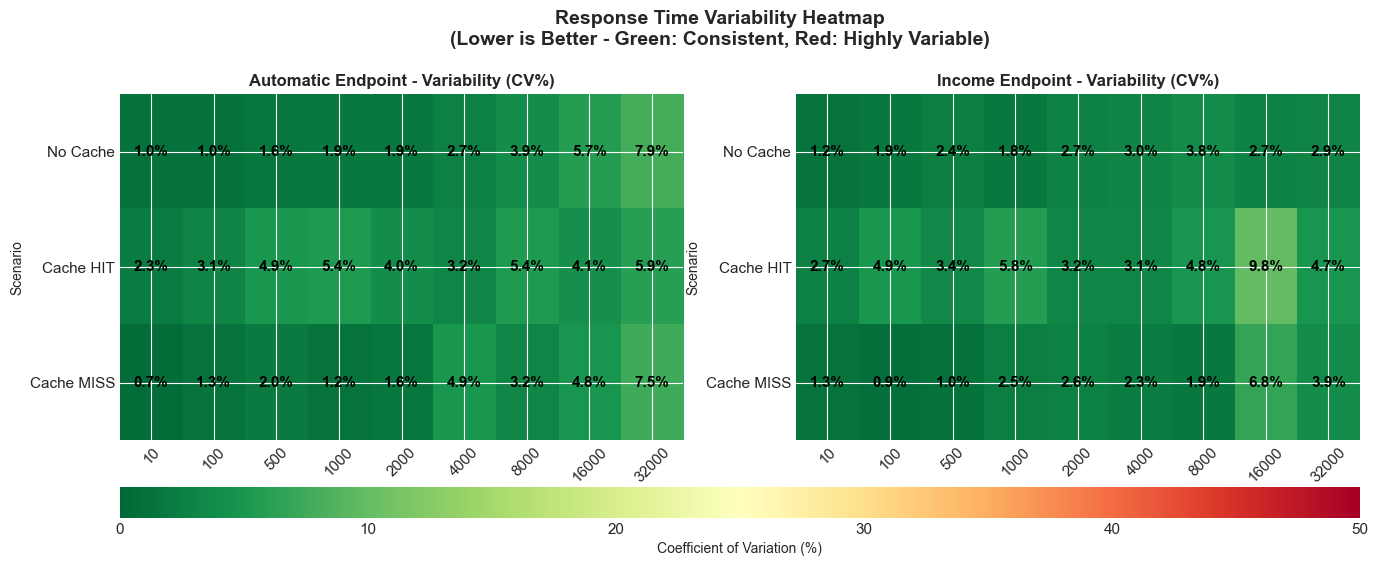


💡 Interpretation:
  • CV% < 10%: Excellent consistency (Green)
  • CV% 10-30%: Moderate variability (Yellow)
  • CV% > 30%: High inconsistency - investigate! (Red)


In [ ]:
# Visualization: Coefficient of Variation (CV%) Heatmap

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, endpoint in enumerate(df['Endpoint'].unique()):
    endpoint_data = df[df['Endpoint'] == endpoint]
    
    # Calculate CV% for each scenario and payload size
    cv_data = []
    for payload in sorted(endpoint_data['PayloadSize'].unique()):
        payload_data = endpoint_data[endpoint_data['PayloadSize'] == payload]
        
        row = {
            'Payload': payload,
            'No Cache': (payload_data['NoCache_Avg_ms'].std() / payload_data['NoCache_Avg_ms'].mean() * 100) if len(payload_data) > 1 else 0,
            'Cache HIT': (payload_data['CacheHit_Avg_ms'].std() / payload_data['CacheHit_Avg_ms'].mean() * 100) if len(payload_data) > 1 else 0,
            'Cache MISS': (payload_data['CacheMiss_Avg_ms'].std() / payload_data['CacheMiss_Avg_ms'].mean() * 100) if len(payload_data) > 1 else 0
        }
        cv_data.append(row)
    
    cv_df = pd.DataFrame(cv_data)
    cv_pivot = cv_df.set_index('Payload').T
    
    # Create heatmap
    im = axes[idx].imshow(cv_pivot.values, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=50)
    
    # Set ticks and labels
    axes[idx].set_xticks(range(len(cv_pivot.columns)))
    axes[idx].set_xticklabels(cv_pivot.columns, rotation=45)
    axes[idx].set_yticks(range(len(cv_pivot.index)))
    axes[idx].set_yticklabels(cv_pivot.index)
    
    # Add text annotations
    for i in range(len(cv_pivot.index)):
        for j in range(len(cv_pivot.columns)):
            value = cv_pivot.values[i, j]
            color = 'white' if value > 25 else 'black'
            axes[idx].text(j, i, f'{value:.1f}%', ha='center', va='center', color=color, fontweight='bold')
    
    axes[idx].set_title(f'{endpoint.capitalize()} Endpoint - Variability (CV%)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Payload Size (records)', fontsize=10)
    axes[idx].set_ylabel('Scenario', fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, aspect=40)
cbar.set_label('Coefficient of Variation (%)', fontsize=10)

plt.suptitle('Response Time Variability Heatmap\n(Lower is Better - Green: Consistent, Red: Highly Variable)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n💡 Interpretation:")
print("  • CV% < 10%: Excellent consistency (Green)")
print("  • CV% 10-30%: Moderate variability (Yellow)")
print("  • CV% > 30%: High inconsistency - investigate! (Red)")

In [ ]:
# Anomaly Detection: Z-Score Analysis

from scipy import stats

print("\n" + "="*80)
print("ANOMALY DETECTION: Z-Score Analysis (Outlier Identification)")
print("="*80)
print("Detecting data points that deviate significantly from the mean (|z| > 3)")

anomaly_summary = []

for endpoint in df['Endpoint'].unique():
    print(f"\n{'='*80}")
    print(f"Endpoint: {endpoint.upper()}")
    print(f"{'='*80}")
    
    endpoint_data = df[df['Endpoint'] == endpoint].copy()
    
    for scenario_col, scenario_name in [
        ('NoCache_Avg_ms', 'No Cache'),
        ('CacheHit_Avg_ms', 'Cache HIT'),
        ('CacheMiss_Avg_ms', 'Cache MISS')
    ]:
        print(f"\n{scenario_name}:")
        
        # Calculate z-scores for each payload size separately
        for payload in sorted(endpoint_data['PayloadSize'].unique()):
            payload_data = endpoint_data[endpoint_data['PayloadSize'] == payload].copy()
            
            if len(payload_data) < 3:
                continue
            
            # Calculate z-scores
            payload_data['z_score'] = np.abs(stats.zscore(payload_data[scenario_col]))
            
            # Find outliers (|z| > 3)
            outliers = payload_data[payload_data['z_score'] > 3]
            
            if len(outliers) > 0:
                print(f"  Payload {payload}: Found {len(outliers)} outlier(s)")
                for _, outlier in outliers.iterrows():
                    print(f"    Run {outlier['RunNumber']}: {outlier[scenario_col]:.2f}ms (z={outlier['z_score']:.2f})")
                    
                    anomaly_summary.append({
                        'Endpoint': endpoint,
                        'Scenario': scenario_name,
                        'PayloadSize': payload,
                        'RunNumber': outlier['RunNumber'],
                        'Value_ms': outlier[scenario_col],
                        'Z_Score': outlier['z_score']
                    })

if len(anomaly_summary) > 0:
    print("\n" + "="*80)
    print("SUMMARY: All Detected Anomalies")
    print("="*80)
    anomaly_df = pd.DataFrame(anomaly_summary)
    print(anomaly_df.to_string(index=False))
    
    print(f"\n📊 Total Anomalies Detected: {len(anomaly_df)}")
    print(f"   By Endpoint: {anomaly_df['Endpoint'].value_counts().to_dict()}")
    print(f"   By Scenario: {anomaly_df['Scenario'].value_counts().to_dict()}")
else:
    print("\n✓ No significant outliers detected (all data points within 3 standard deviations)")


ANOMALY DETECTION: Z-Score Analysis (Outlier Identification)
Detecting data points that deviate significantly from the mean (|z| > 3)

Endpoint: AUTOMATIC

No Cache:

Cache HIT:

Cache MISS:

Endpoint: INCOME

No Cache:

Cache HIT:

Cache MISS:

✓ No significant outliers detected (all data points within 3 standard deviations)


In [ ]:
# Resource Monitoring Anomaly Detection

print("\n" + "="*80)
print("RESOURCE MONITORING: Anomaly Detection")
print("="*80)

# Check for VMs running out of memory
print("\n⚠️ Low Memory Warnings (< 500MB free):")
low_memory_found = False

for vm_prefix in ['K6', 'NoCache', 'CacheHit', 'CacheMiss']:
    min_mem_col = f'{vm_prefix}_MinFreeMemory_MB'
    
    if min_mem_col in df.columns:
        low_mem = df[df[min_mem_col] < 500].copy()
        
        if len(low_mem) > 0:
            low_memory_found = True
            print(f"\n  {vm_prefix} VM:")
            for _, row in low_mem.iterrows():
                print(f"    Payload {row['PayloadSize']}, Run {row['RunNumber']}: {row[min_mem_col]:.1f} MB free (Min)")
                print(f"      Endpoint: {row['Endpoint']}, Avg: {row[f'{vm_prefix}_AvgFreeMemory_MB']:.1f} MB")

if not low_memory_found:
    print("  ✓ No low memory warnings detected (all VMs had >500MB free)")

# Check for high CPU usage
print("\n⚠️ High CPU Usage Warnings (>80% busy):")
high_cpu_found = False

for vm_prefix in ['K6', 'NoCache', 'CacheHit', 'CacheMiss']:
    idle_col = f'{vm_prefix}_AvgCPU_Idle_Pct'
    
    if idle_col in df.columns:
        high_cpu = df[df[idle_col] < 20].copy()  # Less than 20% idle = more than 80% busy
        
        if len(high_cpu) > 0:
            high_cpu_found = True
            print(f"\n  {vm_prefix} VM:")
            for _, row in high_cpu.iterrows():
                user_col = f'{vm_prefix}_AvgCPU_User_Pct'
                sys_col = f'{vm_prefix}_AvgCPU_System_Pct'
                print(f"    Payload {row['PayloadSize']}, Run {row['RunNumber']}: {row[idle_col]:.1f}% idle")
                print(f"      User: {row[user_col]:.1f}%, System: {row[sys_col]:.1f}%, Endpoint: {row['Endpoint']}")

if not high_cpu_found:
    print("  ✓ No high CPU warnings detected (all VMs had >20% idle)")

# Check for correlation between low memory and poor performance
print("\n📊 Correlation: Memory vs Performance:")
for endpoint in df['Endpoint'].unique():
    endpoint_data = df[df['Endpoint'] == endpoint].copy()
    
    # Check K6 VM memory correlation with response times
    if 'K6_AvgFreeMemory_MB' in endpoint_data.columns:
        corr_nocache = endpoint_data[['K6_AvgFreeMemory_MB', 'NoCache_Avg_ms']].corr().iloc[0, 1]
        corr_hit = endpoint_data[['K6_AvgFreeMemory_MB', 'CacheHit_Avg_ms']].corr().iloc[0, 1]
        corr_miss = endpoint_data[['K6_AvgFreeMemory_MB', 'CacheMiss_Avg_ms']].corr().iloc[0, 1]
        
        print(f"\n  {endpoint.capitalize()} Endpoint (K6 Memory vs Response Time):")
        print(f"    No Cache: r={corr_nocache:.3f}")
        print(f"    Cache HIT: r={corr_hit:.3f}")
        print(f"    Cache MISS: r={corr_miss:.3f}")
        
        if abs(corr_nocache) > 0.5 or abs(corr_hit) > 0.5 or abs(corr_miss) > 0.5:
            print(f"    ⚠️ Moderate to strong correlation detected - memory may be impacting results!")


RESOURCE MONITORING: Anomaly Detection

⚠️ Low Memory Warnings (< 500MB free):

  K6 VM:
    Payload 10, Run 1: 411.4 MB free (Min)
      Endpoint: automatic, Avg: 417.7 MB
    Payload 10, Run 10: 410.9 MB free (Min)
      Endpoint: automatic, Avg: 417.3 MB
    Payload 10, Run 2: 402.8 MB free (Min)
      Endpoint: automatic, Avg: 404.5 MB
    Payload 10, Run 3: 402.1 MB free (Min)
      Endpoint: automatic, Avg: 402.1 MB
    Payload 10, Run 4: 413.2 MB free (Min)
      Endpoint: automatic, Avg: 415.9 MB
    Payload 10, Run 5: 400.6 MB free (Min)
      Endpoint: automatic, Avg: 401.5 MB
    Payload 10, Run 6: 400.6 MB free (Min)
      Endpoint: automatic, Avg: 400.6 MB
    Payload 10, Run 7: 400.6 MB free (Min)
      Endpoint: automatic, Avg: 400.6 MB
    Payload 10, Run 8: 400.2 MB free (Min)
      Endpoint: automatic, Avg: 400.3 MB
    Payload 10, Run 9: 399.7 MB free (Min)
      Endpoint: automatic, Avg: 400.1 MB
    Payload 10, Run 1: 401.1 MB free (Min)
      Endpoint: income, Av